[View in Colaboratory](https://colab.research.google.com/github/stephanielong12/hello-world/blob/master/Copy_of_workshop_live_SPR2018.ipynb)

# PART 0 : Installing and downloading requirements

In [0]:
%%capture
!pip3 install -U cython nibabel lxml numexpr shapely 

In [2]:
!git clone https://github.com/gallantlab/pycortex/

Cloning into 'pycortex'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 12824 (delta 11), reused 17 (delta 7), pack-reused 12798
Receiving objects: 100% (12824/12824), 149.18 MiB | 35.95 MiB/s, done.
Resolving deltas: 100% (9230/9230), done.


In [3]:
cd /content/pycortex

/content/pycortex


In [0]:
%%capture
%run setup.py install

In [6]:
cd /content

/content


In [0]:
%%capture
!pip3 install datascience mne
!pip3 install -U git+git://github.com/choldgraf/neurods

In [9]:
from neurods.io import download_file

download_file('https://www.dropbox.com/s/x0wfftq6dkg0fsf/data.zip?dl=1',
              'data.zip',root_destination='/content/')

# https://drive.google.com/file/d/1OX8eIYTSGaCpscbKrpzAoqDXo408OGZi/view?usp=sharing

Creating data folder...
Creating tmp folder...
[........................................] 100.00% (247.0 MB, 104.7 MB/s) |   
File saved as /content/data.zip.

Successfully moved file to /content/data.zip


In [0]:
%%capture
!unzip /content/data.zip

In [0]:
mv data/MNI /usr/local/share/pycortex/db/

In [0]:
from IPython.display import Image
import nibabel
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
### this is all you would need if you were in python

#  PART 1 : Introduction to functional magnetic resonance imaging (fMRI)




## 1.1 Short overview of fMRI 

Functional Magnetic Resonance Imaging, or fMRI, is a measure of brain activity over time. FMRI data is acquired using a special pulse sequence designed to measure changes in the magnetic properties of the blood flow using the Magnetic Resonance Imaging (MRI) scanner.

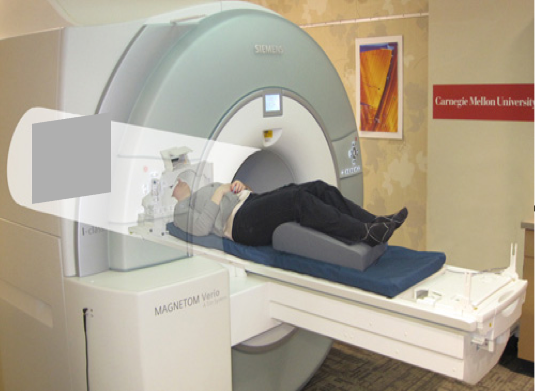

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/mri_scanner.png")

The functional signal we measure with fMRI is *not* an electrical neural signal (as in EEG, ECoG, or electrophysiology). It is a magnetic signal related to the properties of brain tissue, and it is dominated by blood flow. Blood flow is related to neural activity, because firing neurons need oxygen. The process of firing involves letting electrically charged ions into a cell and actively pumping them back out again, which is metabolically demanding. So once a region of the brain becomes active (once the neurons start firing), metabolism in that region is high, oxygen gets stripped off of hemoglobin molecules in red blood cells in the area (thereby changing the magnetic properties of hemoglobin, creating a deoxyhemoglobin). This initiates a complex process to increase blood flow to the electrically active area. 

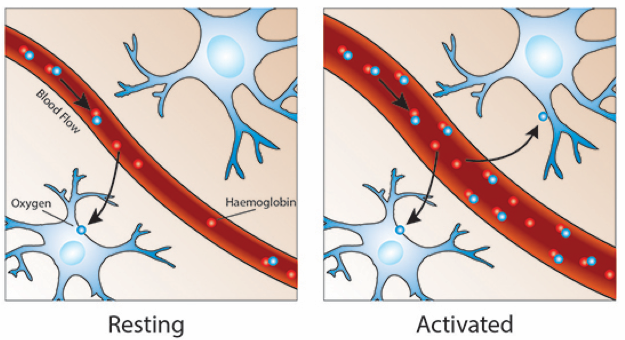

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/deoxyhemoglobin.png")

The specific mechanisms that lead from neural activity to changes in blood flow are (a) not well understood, and (b) beyond the scope of this tutorial. For now, just know that there are several ways to measure functional responses with MRI, and the specific one that we work with is the Blood Oxygenation Level Dependent Response, or the BOLD response. 

**fMRI has high spatial but low temporal resolution**

We have belabored this here a little because this complexity should always be a source of humility for anyone working with fMRI or trying to interpret fMRI results. It is an **indirect, slow measure** - and these considerations strongly constrain the kinds of experiments you can do with fMRI and the conclusions you can draw from those experiments.

An important practical upshot of this for our purposes is that the signal we measure changes much more slowly than the signal we measure in EEG or ECoG. Responses emerge over seconds, not milliseconds.

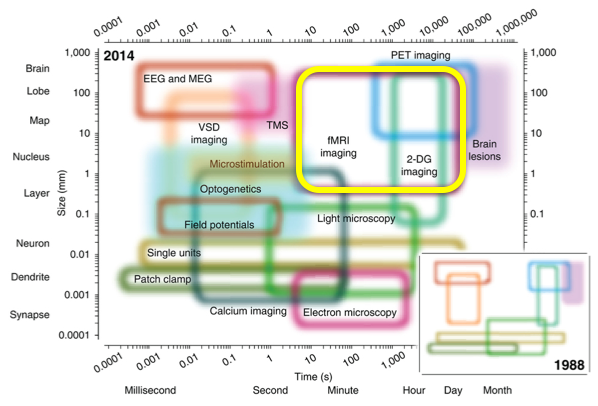

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/imaging_modalities.png")

                                      Sejnowski et al., Nature Neurosci., 2014




One fMRI image (fMRI volume) is acquired for a given unit of time called a repetition time (TR). A TR is typically 1-2 seconds *(usually 1.0, 1.5, or 2.0 seconds)*. Every image records the activity in the brain at a given point in time. The following image shows a single volume of fMRI data (one two-second snapshot of brain activity).

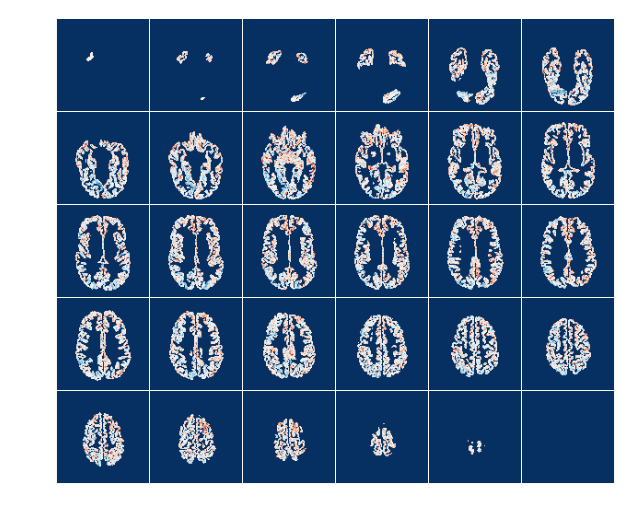

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/fig1.png")

The dimensions of the brain volume measured by fMRI can vary. Each individual fMRI measurement unit is called a *voxel*, which is short for volumetric pixel. The voxels in this data are about 2.4 x 2.4 x 4.0 mm$^3$ (X x Y x Z) in size. 

**FMRI activity in time**

Once a neural event is triggered by a stimulus presentation the vascular system needs to respond to the need for glucose and oxygen in that specific brain area. This can take up to 1-2 seconds. Hence the hemodynamic response lags the triggered event by 1-2 seconds, which peaks around 5 seconds after the stimulus onset.

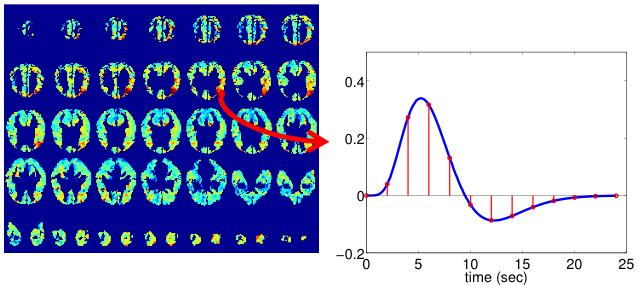

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/lagged_activity.png")

**Example fMRI experiments **

Viewing natural images 

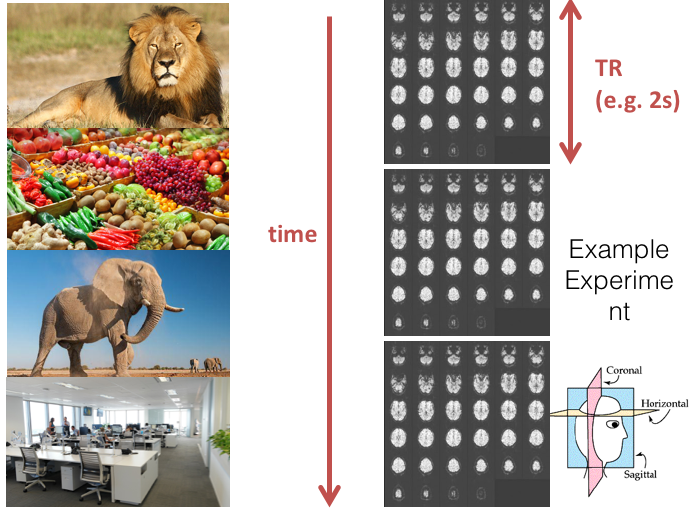

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/fmri_example_experiment.png")

Fusiform Face Area (FFA)

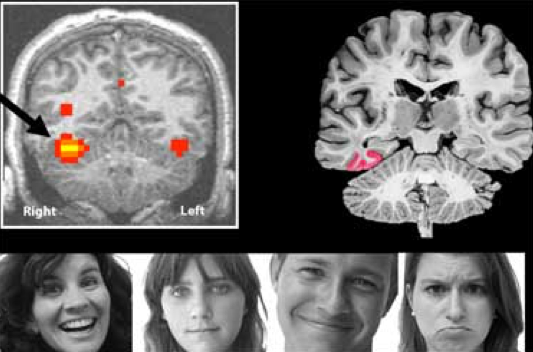

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/ffa.png")

**FMRI as a *mapping* technique**
One of the scanning volume for the data we will use here consists of 30 transverse slices (i.e. Z is between 0 and 29). Transverse slices are horizontal, i.e., approximately parallel to the plane of the eyes and ears. Each slice corresponds to a 2D image of 100 x 100 voxels.

We can measure fMRI responses across the whole brain. Therefore fMRI can be seen as a *mapping* technique. In order to make brain maps, we have to be able to match measured voxel responses to the participant's brain anatomy. Using a different type of MRI sequence, we can collect a **structural scan** (also called **anatomical scan**), and obtain a high resolution image of a participant's brain. Here is an example:

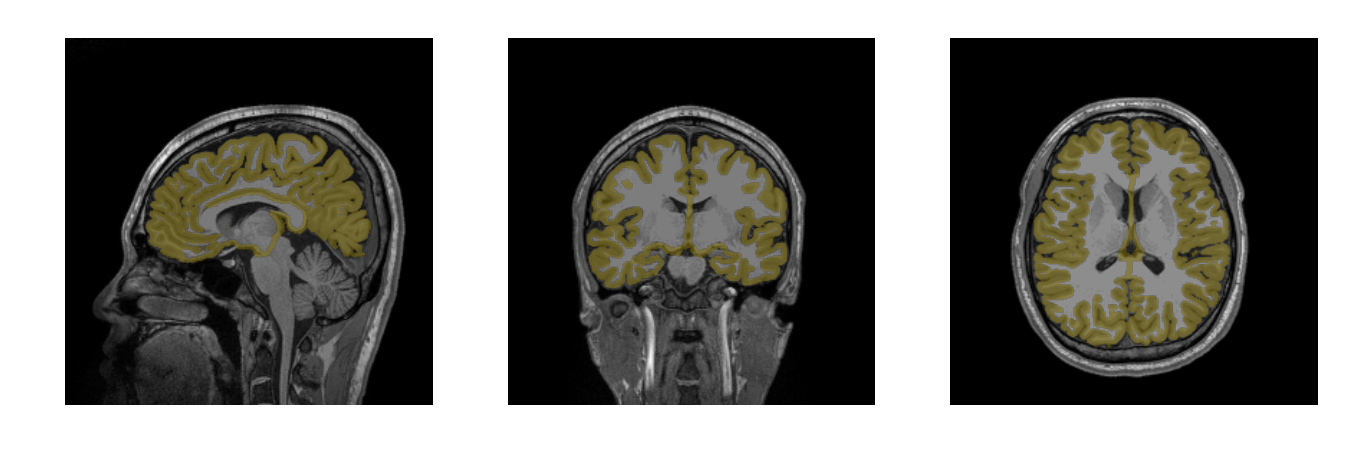

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/MPRAGE_wcortex.png")

Most MRI measures activity in the cerebral cortex, or the outer layer of the brain. Using automated reconstruction software (and some manual editing), it's possible to build a 3D representation of the shape of the subject's cerebral cortex:

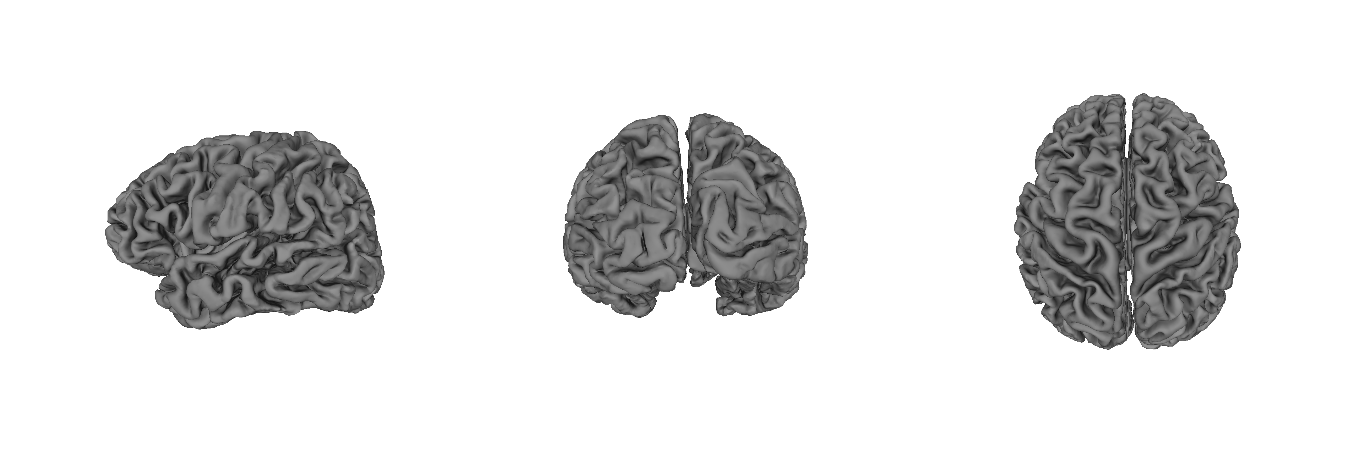

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/cortex_3views.png")

W will learn how to overlay functional data onto the high resolution cortical representation for each individual the subject, so that we can make sense of the data.


** Storing fMRI data for data analysis**

We store fMRI data as a matrix. This means that each volume (a timepoint) in the experiment will correspond to a row in the matrix, and each voxel will correspond to a column in that matrix. For this reason, we need to make sure the criteria we use to move each 3D image to a matrix row is preserved and this operation is inverted. Let's look at an example.

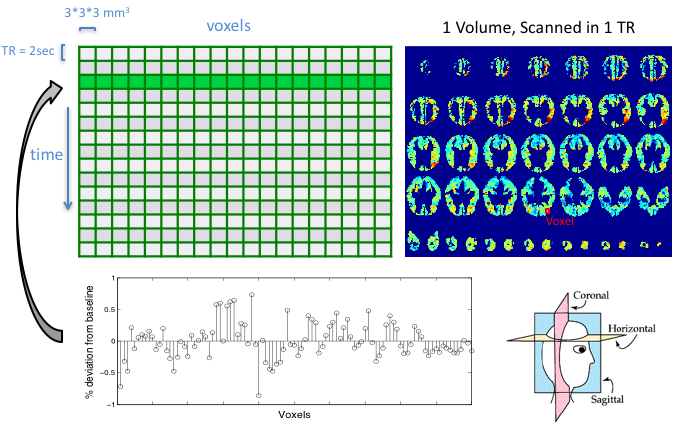

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/fmri_dimensions.png")

## 1.2 Loading data

fMRI data is stored in a variety of formats. The medical imaging community has a standardized image format called Digital Imaging and Communications in Medicine (DICOM) to handle and store raw medical imaging data. When data is collected using the MRI scanner each volume is stored in a DICOM file that contains both a header and the image data. The DICOM header stores useful information about the participant's name, pulse sequence, the type of scan, image dimensions, etc. (Another popular medical imaging format is the Analyze format, where the image and header file are stored separately.) You can read about these file formats [here](http://people.cas.sc.edu/rorden/dicom/index.html).

Before we start analyzing the data we convert the raw DICOM files into the commonly used Neuroimaging Informatics Technology Initiative (nifti) file format. Files stored in this format usually have the extension .nii or .nii.gz. 

We will use the `nibabel` python module to load data that is stored such data formats.

In the following we will load one run (also referred to as a scan) worth of fMRI data that was stored as a nifti file format. 

In [0]:
# Create load the fMRI data
fname = 'data/sub01_categories1.npy'
data = np.load(fname) 
data = data.astype('float32')

print('data.shape : ', data.shape)

**The print function**
There are multiple ways to use the print function in python:

In [0]:
print('The first dimension of the data is: ', data.shape[0], 'and the second dimension is: ', data.shape[1])
print('The first dimension of the data is: {0} and the second dimension is: {1}'.format(data.shape[0], data.shape[1]))

**Super quick intro to arrays in python**

You can make arrays in python using lists:

In [0]:
row1 = [1, 2, 3, 4]
row2 = [5, 6 ,7 , 8]
row3 = [9, 10, 11, 12]
example_array = np.array([row1, row2, row3])
print(example_array)

Another way to create the array above is by using the function range, which creates a list of successive numbers:

In [0]:
row1 = range(1,5)
row2 = range(5,9)
row3 = range(9,13)
example_array_2 = np.array([row1, row2, row3])
print(example_array_2)

An of course you can create arrays with arbitrarily values:

In [0]:
row1 = [3, -2, 2, 9.3]
row2 = [-5, 3 ,2 , 22]
row3 = [72, 12, 1.4, 2]
example_array_2 = np.array([row1, row2, row3])
print(example_array_2)

Let's print the shape of the array:

In [0]:
print("This array has shape {}.".format(example_array_2.shape))

One can use the .T notation to obtain a transpose:

In [0]:
row1 = range(1,5)
row2 = range(5,9)
row3 = range(9,13)
B = np.array([row1, row2, row3])
Bt = B.T
print(B)
print("This array has shape {}.".format(B.shape))
print(Bt)
print("This array has shape {}.".format(Bt.shape))

These were 2 dimensional arrays. Let's explore 3 dimensional arrays:

In [0]:
a1 = range(1,5)
a2 = range(5,9)
a3 = range(9,13)
A1 = np.array([a1,a2,a3])
print("A1:")
print(A1)
print("This array has shape {}.".format(A1.shape))

a4 = range(13,17)
a5 = range(17,21)
a6 = range(22,26)
A2 = np.array([a4,a5,a6])
print("A2:")
print(A2)
print("This array has shape {}.".format(A2.shape))

A_3d = np.array([A1,A2])
print("A_3d:")
print(A_3d)
print("This array has shape {}.".format(A_3d.shape))

What happens when you transpose a 3d array?

In [0]:
A_3d_t = A_3d.T
print("A_3d_t:")
print(A_3d_t)
print("This array has shape {}.".format(A_3d_t.shape))

The order of the dimensions is inverted (e.g. the last dimension becomes the first dimension).

Let's go back to our loaded 4D fMRI data:

In [0]:
print('The shape of the data is: {0}'.format(data.shape))
print('Each volume has {0} entries on the X axis, {1} on Y, {2} on Z. There are {3} volumes.'.format(
        data.shape[0],data.shape[1],data.shape[2],data.shape[3]))

The dimensions of the data are (X, Y, Z, T) (T is time, in TRs). Thus, there are 360 volumes (360 time points). Each volume has 30 horizontal or transverse slices with 100 x 100 pixels.

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop//slices.png")

**Transpose data**

When we work with functional images it is in general more convenient (for reasons like averaging over time, transfering data to a standard units, etc.) to have the data in T, Z, Y, X format. The reasons for this convention will become more obvious as we go, and we see how this convention makes for convenient syntax and shortcuts. 

Hence, we will use the `transpose` function  of the numpy package (or `.T` method of numpy arrays) to make this dimensional switch.

In [0]:
# Transpose the data
dataT = data.T

print("data shape :", data.shape)
print("dataT shape : ", dataT.shape)

## 1.3 Exploring the data

For fMRI, the functions we will use to explore the data are in general somewhat basic. We will construct our own functions for looking at the data!

This is a little bit of work, but is very generalizable to other kinds of analyses, and if you get good at it you can make exactly the plot of your data that you want.

One of the first questions about a data set (after its size) that you should explore is 

    "What is the scale (min/max) of the data?". 

Afterwards you may be interested to know its mean, standard deviation, and how in general the data looks like and make a histogram plot of the data.

In [0]:
# Keep data transposed
data = dataT

del dataT
print(data.shape)
print('There are {0} volumes. Each volume has {1} entries on the Z axis, {2} on Y, {3} on Z. '.format(
        data.shape[0],data.shape[1],data.shape[2],data.shape[3]))

**Breakout Session**

Now that the data is in a ready to use format, we will explore it.

- Using the functions np.min and np.max, print the minimum and maximum values of the data.
- Using np.mean, print the average value of the data.
- Using np.std, print the standard deviation of the data. 

In [0]:
### ANSWER

Now let's introduce the function flatten:

In [0]:
row1 = range(1,5)
row2 = range(5,9)
row3 = range(9,13)
B = np.array([row1, row2, row3])
print('B:')
print(B)
print('Flattened B:')
print(B.flatten())

What does flatten do?

In [0]:
# Make a histogram of the data
print(data.shape)
print('First 10 values of flattened data:')
print(data.flatten()[:10])
_ = plt.hist(data.flatten(), bins=50)

- What does this tell you about the data? 
- What are the axes on this plot? 
- Why is there so many zeros?

Changing matplotlib default parameters
​
You can set the default colormap, default interpolation or many other parameters in `matplotlib.rcParams`.
​
For example to set all the colormaps in this `ipython` session to the colormap 'viridis' we can use the following line:
    * `matplotlib.rcParams['image.cmap'] = 'viridis'` # or whatever your favorite map is

In [0]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['lines.linewidth'] = 1
# plt.rcParams['axes.grid'] = True

** Plot the timecourse of a single voxel**
Now we can plot the timecourse for one voxel somewhere in the middle of the brain (e.g. at Z=10, Y=34, X=34)

In [0]:
_ = plt.plot(data[:, 10, 45, 45])

Now let's chose X=45 and Y = 45 (or other values). This is a transverse slice. We have 120 time points for each of 30 Z locations. Let's plot these:

In [0]:
voxels_by_time = data[:,:,45,45]
plt.plot(voxels_by_time);
plt.xlabel('time')
plt.ylabel('fMRI activity')


Let's make a legend for this plot. 

In [0]:
legend = []
for i in range(30):
    legend.append('Z = {}'.format(i))
    
print(legend)

legend = ['Z = {}'.format(i) for i in range(30)]

print(legend)

In [0]:
plt.figure(figsize=(10,10))
plt.plot(voxels_by_time);
plt.xlabel('time')
plt.ylabel('fMRI activity')
plt.legend(legend,bbox_to_anchor=(1.1, 1));

What do you notice? Do different Z locations have the same mean? Is that mean useful? Does it seem like we need to normalize them?

Another way of looking at this data is to plot the transpose of the transverse matrix above:

Here is how you make the minimum of every column be 0: 

In [0]:
voxels_by_time_min0 = voxels_by_time - np.min(voxels_by_time, axis = 0)
plt.figure(figsize=(10,10))
plt.plot(voxels_by_time_min0);
plt.xlabel('time')
plt.ylabel('fMRI activity')
plt.legend(legend,bbox_to_anchor=(1.1, 1));

In [0]:
voxels_by_time_min0max1 = voxels_by_time_min0 / np.max(voxels_by_time_min0, axis = 0)
plt.figure(figsize=(10,10))
plt.plot(voxels_by_time_min0max1);
plt.xlabel('time')
plt.ylabel('fMRI activity')
plt.legend(legend,bbox_to_anchor=(1.1, 1));

# PART 2 : fMRI data manipulation in 3D: loading and plotting raw data in python

In this section, we will learn about fMRI data properties by manipulating and visualizing it.


## 2.1 Displaying data as an image

First, we will get a broader view of the first volume of our data. The (T, Z, Y, X) dimension ordering that we have for the data makes it easy to select volumes (time snapshots of brain activity).


Below are some ways to select volumes:

In [0]:
# We can select one volume like this: 
first_volume = data[0, :, :, :]

# Or like this: 
alt_first_volume1 = data[0, ...]

# Or like this: 
alt_first_volume2 = data[0]

# These are all the same1
print( np.all(first_volume == alt_first_volume1) )
print( np.all(first_volume == alt_first_volume2) )

In [0]:
first_volume.shape

**Breakout session**

- select c1 as the 25th volume, print the shape.
- select c2 as all the data for Y = 35, print the shape.
- select c3 as all the time points for X = 10, print the shape.
- select c4 as all the time points for Z = 12, print the shape.
- select c5 as all the time points for Z = 12, Y = 35, X = 10, print the shape.

In [0]:
### ANSWER
c1 = 
print(c1.shape)

** Visualizing the horizontal slice**

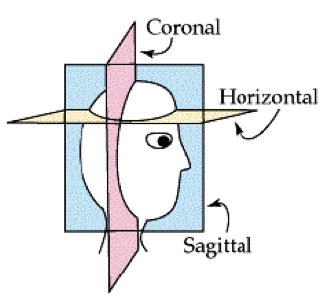

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop/slices.png")

Let's look at an example of a horizontal slice from the first volume. This can be done by selecting one of the slices as follows:

In [0]:
first_volume = data[0, :, :, :]
print(first_volume.shape)

# Z=15 is halfway through the volume we have scanned
slice_horizontal = first_volume[15,:,:] 

# You can set the image origin [0,0] to be in the lower left corner
# by using origin='lower'
plt.figure()
im = plt.imshow(slice_horizontal, origin='lower',  interpolation='nearest', aspect='auto',
                 cmap='viridis', vmin=0, vmax=2000)
_ = plt.grid(False)
_ = plt.colorbar(im)

plt.title('This is a horizontal slice!')

**Breakout session: **
> - Plot other slices to see how the shape of the brain is different
> - Change the properties of the figure. Explore the keyword arguments for imshow, see what each does! (hints: show axes, change colormap, what about vmin and vmax values, set those)

In [0]:
### ANSWER


### 2.1.2 Plotting functions
Here we will write a small helper function that takes a slice number as an input returns the data (2D array) of that slice.

In [0]:
def get_any_slice(volume, slice_number, dimension):
    """Given an integer and a 3D volume, this function returns the data of 
    that horizontal slice """ 
    if dimension == 0:
        img = volume[slice_number, :, :]
    elif dimension == 1:
        img = volume[:, slice_number, :]
    elif dimension == 2:
        img = volume[:, :, slice_number]
    return img

img = get_any_slice( first_volume, 40, 1)
print(img.shape)
_ = plt.imshow(img, origin = 'lower', interpolation='nearest', aspect='auto',
                cmap='viridis', vmin=0, vmax=2000)
_ = plt.grid(False)
_ = plt.axis('off')


We can also make a function that produces the plot above, and uses the get_any_slice() function:

In [0]:
def plot_any_slice(volume, slice_number, dimension):
    img = get_any_slice( volume, slice_number, dimension)
    _ = plt.imshow(img, origin = 'lower', interpolation='nearest', aspect='equal',
                cmap='viridis', vmin=0, vmax=2000)
    _ = plt.grid(False)
    _ = plt.axis('off')
    
plt.figure()
plot_any_slice(first_volume, 10, 0)
plt.title('horizontal slice');
plt.figure()
plot_any_slice(first_volume, 40, 1)
plt.title('coronal slice');
plt.figure()
plot_any_slice(first_volume, 40, 2)
plt.title('sagittal slice');

One way to change a figure's properties is to create a dictionary of keywords that can be used as a  keyword argument to the `imshow` function.

This has the advantage of not setting the default parameters. Yet, we can easily change a number of parameters in the `imshow` function by just passing the keywords dictionary to the `imhsow` function. The following cell is demonstrating this:

In [0]:
im_kws = dict(origin = 'lower', aspect='auto', vmin=0, vmax=2000, cmap='hot', interpolation='nearest') 

# Question: what is a python dictionary?

plt.imshow(first_volume[:,  30, :], **im_kws)
plt.colorbar();

** Modifying parameters**

We can see above that we might want to give different settings to different plots. Let's improve our plotting function.

In [0]:
im_kws = dict(origin = 'lower', aspect='auto', vmin=0, vmax=2000, cmap='hot', interpolation='nearest') 


def plot_any_slice(volume, slice_number, dimension, origin = 'lower', interpolation='nearest', aspect='equal',
                cmap='viridis', vmin=0, vmax=2000):
    img = get_any_slice(volume, slice_number, dimension)
    _ = plt.imshow(img, origin = origin, interpolation=interpolation, aspect=aspect,
                cmap=cmap, vmin=vmin, vmax=vmax)
    _ = plt.axis('off')
    
plt.figure()
plot_any_slice(first_volume, 10, 0,**im_kws)
plt.title('horizontal slice');
plt.figure()
plot_any_slice(first_volume, 40, 1,**im_kws)
plt.title('coronal slice');
plt.figure()
plot_any_slice(first_volume, 40, 2,**im_kws)
plt.title('sagittal slice');

**Plot all horizontal slices**

Let's try to make a plot with all of the horizontal slices, so we can see one entire 3D volume at once. For this, we will use the `subplot()` function in matplotlib:

In [0]:
fig = plt.figure(figsize = (8,8))
slice_dimension = 0
n_slices = first_volume.shape[slice_dimension]
nrows, ncols = 5, 6
for s in range(n_slices):
    ax = fig.add_subplot(nrows, ncols, s+1)
    plot_any_slice(first_volume, s, slice_dimension,**im_kws)

Now let's make a function that plots the above:

In [0]:
def plot_all_slices(volume, slice_dimension, nrows, ncols , cmap = 'viridis', vmin=0, vmax=2000,
                     origin = 'lower', interpolation='nearest', aspect='equal' ):
    fig = plt.figure(figsize = (8,8))
    n_slices = volume.shape[slice_dimension]
    for s in range(n_slices):
        ax = fig.add_subplot(nrows, ncols, s+1)
        plot_any_slice(volume, s, slice_dimension, cmap = cmap, vmin= vmin, vmax = vmax, 
                          origin = origin, interpolation = interpolation,aspect = aspect)    

In [0]:
plot_all_slices(first_volume, 0, 5, 6)
plt.suptitle('horizontal slices');

In [0]:
plot_all_slices(first_volume, 1, 10, 10)
plt.suptitle('coronal slices');

In [0]:
plot_all_slices(first_volume, 2, 10, 10)
plt.suptitle('sagittal slices');

## 2.2 Data normalization

In [0]:
bins = np.linspace(250, 650, 31)
voxel_a = data[:, 5, 50, 43]
voxel_b = data[:, 5, 50, 53]
_ = plt.hist(voxel_a, bins, label='Voxel A')
_ = plt.hist(voxel_b, bins, label='Voxel B')
plt.legend()

In [0]:
def minmax_norm(data):
    """Normalize data to range of 0-1 by subtracting min, dividing by range"""
    data_norm = (data-data.min()) / (data.max()-data.min())
    return data_norm

In [0]:
bins01 = np.linspace(0,1,31)
voxel_a_n = minmax_norm(voxel_a)
voxel_b_n = minmax_norm(voxel_b)
_ = plt.hist(voxel_a_n, bins01, label='Voxel A')
_ = plt.hist(voxel_b_n, bins01, label='Voxel B')
plt.legend()

Looks sensible. However, a problem with this normalization method shows up when you have outlying values. What would happen if Voxel A, at one time point, had a (spuriously) very large value? Let's see!

In [0]:
# Aside: a cautionary tale. Python memory is weird.
a = np.arange(10)
b = a
b[3] = 63
print(a)

In [0]:
# You can avoid changing a variable by using the copy package
import copy
a = np.arange(10)
b = copy.copy(a)
b[3] = 63
print(a)

In [0]:
# Create a variable called voxel_a_wonky and add an outlier to it
voxel_a_wonky = copy.copy(voxel_a)
voxel_a_wonky[5] = voxel_a_wonky.max()*1.5

In [0]:
# See what that outlier does to histogram plots created after our first normalization method!
_ = plt.hist(minmax_norm(voxel_a_wonky), bins01, label='Voxel A (w/ outlier)')
_ = plt.hist(minmax_norm(voxel_b), bins01, label='Voxel B')
plt.legend()

This does not put the data from both voxels into a similar range, because the max value is not stable (it can change a lot depending on only one data point). In general, (linear) data normalization set you need to *center* it (by subtracting off some value) and to *scale* it (by dividing by some value or performing some nonlinear operation). 
A more robust, stable way to normalize data is to subtract the *mean* of the data instead of the min, and to divide by the *standard deviation* instead of the range. 

The *standard deviation* is a measure of the variability of the data, derived from the whole data set (rather than the two points - the min and the max - that we used before.)

This process converts the data to *standard scores* or *z scores*. 

In [0]:
# You can compute the standard deviation of voxel A and voxel B using 
print(np.std(voxel_a), ',', np.std(voxel_b))
# or: 
print(voxel_a.std(), ',', voxel_b.std())

**Breakout session**

Perform normalization of Voxel A and Voxel B by (1) subtracting off the mean (**`array.mean()`** or **`np.mean(array)`**) and (2) dividing by the standard deviation (**`array.std()`** or **`np.std(array)`**)

Then repeat the plots we created above (making histograms of the timecourses for Voxel A, with and without an outlier, and for Voxel B)

In [0]:
### ANSWER


z normalization can be performed easily on multi-dimensional arrays using the `zscore` function in scipy.stats. 

In [0]:
from scipy.stats import zscore
zscore?

In [0]:
data_z = zscore(data, axis=0)

Now we can repeat a few of the plots we made above, to show that we now see more variation across time than across voxels.

In [0]:
# Plot time x voxels
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.imshow(data_z.reshape(360, -1), aspect='auto', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('Voxels')
plt.ylabel('Time (TRs)')


In [0]:
data_z = np.nan_to_num(data_z)

In [0]:
# Plot time x voxels
plt.figure(figsize=(10,4))
plt.imshow(data_z.reshape(360, -1), aspect='auto', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('Voxels')
plt.ylabel('Time (TRs)')

In [0]:
# Plot 
first_volume_z = data_z[0]
plot_all_slices(first_volume_z, 0, nrows=6, ncols=6,vmin = -3, vmax = 3)

##  2.3 Cortical surface extraction

fMRI studies often focus on the cerebral cortex (the outermost layer of the brain). Consequently, it is common to display the results of statistical analyses of fMRI data on inflated and flattened representations of the cerebral cortex. Such cortical surface maps provide a way to examine all cortical fMRI data at once, with the anatomical location of the functional data made clear. 

The cortical surface must be computationally extracted from high spatial resolution anatomical MRI scans, and often manually edited (*NOTE: Manual editing to create a good corical surface can take days or weeks of effort! This data is not free!*)

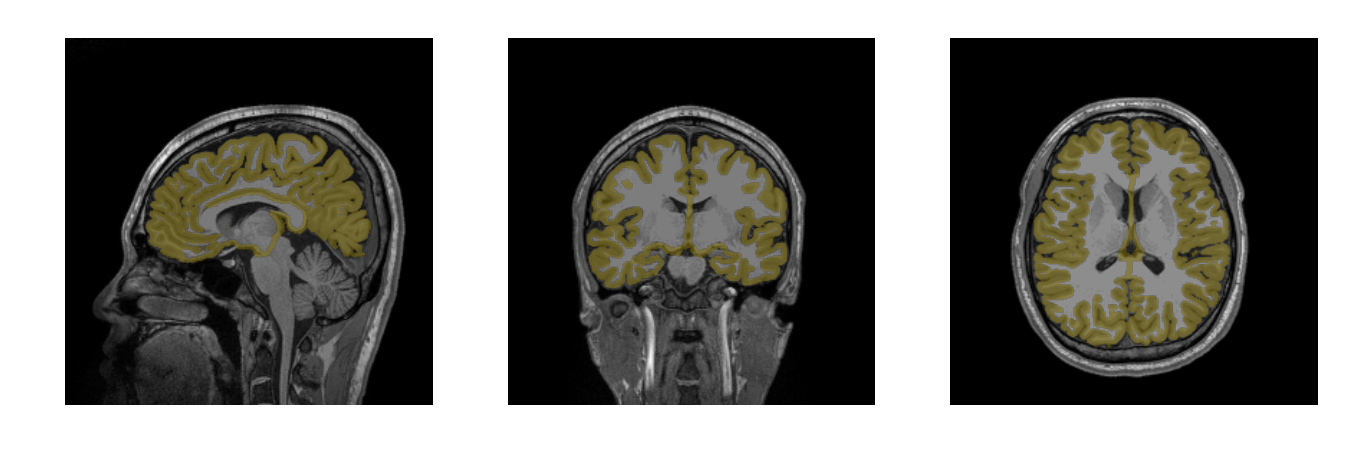

In [0]:
Image("http://www.cs.cmu.edu/~lwehbe/files/workshop//MPRAGE_wcortex.png")

Remember our histogram of values for data, which show a ton of voxels with zero values (from outside the brain).

### 2.4 Masking 



In [0]:
# load s01's mask

cortical_voxels = np.load('data/s01_mask.npy')

In [0]:
# Display the same information as the brain mask above
print(cortical_voxels.dtype)
print(cortical_voxels.shape)
print(cortical_voxels.sum())
print(cortical_voxels.mean())

In [0]:
# Plot 
fig1 = plt.figure(figsize=(6,5))
plot_all_slices(cortical_voxels, 0 , nrows = 6, ncols = 6, vmin = 0, vmax = 1)

In [0]:
cortical_data = data_z[:, cortical_voxels]
print(cortical_data.shape)

In [0]:
# Plot time x voxels
plt.figure(figsize=(10,4))
plt.imshow(cortical_data, aspect='auto', vmin=-3, vmax=3)
plt.xlabel('Voxels')
plt.ylabel('Time (TRs)')
plt.grid(False)

In [0]:
data_z[:,cortical_voxels==False] = 0
plot_all_slices(data_z[:36,10,:,:], 0 , nrows = 6, ncols = 6, vmin = -3, vmax = 3,cmap = 'RdBu_r')

# PART 3 : fMRI hemodynamic response function and convolution

In this section, we will learn about the hemodynamic response function and how *convolve* a signal with this function.

In the previous section, we computed event-related averages for responses to different categories of objects. We saw that responses in fMRI emerge slowly (2-3 TRs or 4-6 seconds) after the onset of a stimulus.

In an fMRI experiment, we usually would like to know how some event is related to brain responses and where in the brain we can find representations of these events. Using the event related averages we can investigate which brain regions respond more to a particular stimuli than others. To drive any valid conclusions from the fMRI data we need to make sure that our events model the actual changes in the brain. By modeling the delay that is inate to the fMRI signal, we can later try to find a direct mapping between the event and the brain response.


**fMRI responses do not occur immediately after a stimulus**

fMRI responses emerge slowly after the onset of a stimulus (or any other event). This means that, if we want to make an accurate mathematical model of how the brain responds to a given stimulus, we have to incorporate this delay into our model. 

To do this, we will borrow a concept from signal processing theory called the impulse response function. An impulse response function describes a system's response (this can be the signal that we measure using fMRI) to an external change (e.g. the stimulus or event onset). As we know, fMRI measures BOLD signal and not neuronal activity directly. Therefore, to model the hemodynamic response (BOLD signal) to an event we would like to have a function that describes how the BOLD signal looks like when it responds to a given event. This function is called the *hemodynamic response function* or HRF. 

A great deal of early fMRI research went into accurately describing how the BOLD signal rises, falls, and resets to baseline after an event. We will rely on the conclusions of this research without going into much detail about it. For an overview of hemodynamic responses in fMRI, check out [this blog post](http://mindhive.mit.edu/node/72). The practical upshot of this work is that BOLD responses have a fairly characteristic shape, which is well described by a mathematical function called the *gamma function*. 


**Generate and plot the hemodynamic response function**

Below we will use the fmri module in the neurods package to generate a canonical HRF:

`neurods.fmri.hrf()`

In [0]:
# Let's check what arguments this function takes
from neurods.fmri import hrf as generate_hrf
generate_hrf??

In [0]:
# Set the TR, or repetition time, a.k.a. the sampling rate
TR = 1.0 # One measurement per second

# Get a canonical HRF
t_hrf, hrf_1 = generate_hrf(tr=TR)
print('hrf_1 shape is', hrf_1.shape)
__ = plt.plot(t_hrf, hrf_1)
plt.title("Canonical HRF")

**Plot a single discrete stimulus**

In [0]:
# Plot a single discrete stimulus that appears at time 0
t = t_hrf
stimulus = np.zeros(t.shape)
stimulus[0] = 1

plt.figure(1, figsize=(10, 5))
plt.subplot(121)
plt.plot(t, stimulus)

# There is a better function that we can use to make this plot more explicit
#plt.subplot(122)
#plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus')

** The HRF is the BOLD response to this single discrete stimulus**

Let's plot the HRF together with the stimulus

In [0]:
# We will be plotting stimulus / response pairs several times
# Hence, here is a function that can plot these two together
def stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2), label_stim='Stimulus', label_resp='BOLD response (HRF)'):
    """Plot stimulus and response."""
    plt.figure(figsize=(10,4))
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label=label_stim)
    plt.plot(t, response, 'r.-', label=label_resp)
    plt.ylim(yl)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot
stim_resp_plot(t, stimulus, hrf_1)

### 3.1 Breakout sessions part 1
Play with the parameters of the `neurods.fmri.hrf()` function. See what happens if you change them. 

In [0]:
### ANSWER


Every time an event occurs, the response we measure is similar to this slow hemodynamic response. We will slowly explore how this hemodynamic response can affect the signal in a voxel.

First, we start with a hypothetical run of 200 TRs, in which no stimuli is presented.

In [0]:
n = 200 # Total time points (TRs)
t = np.arange(n,)

# No stimulus
stimuli = np.zeros((n))

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)

# We assume no response
response = np.zeros((n))

# Here we plot the function
# stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

**Breakout session (a)**

A few cells above we plotted how the signal changes when we have a stimulus at time 0. 

Now, imagine we have a stimulus at time `i=10`. What do you expect will happen when we plot the stimulus and response?

Hint: This stimulus will create an HRF that will be *added* to the signal from times i to times i + hrf_length (hrf_length is the length of our canonical HRF, which was 32 above).

Attention: Make sure you modify the response by adding something to it's values, and not only changing it.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

# Add a stimlus onset at time 10
i = 10
stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)

# Now add the response to stimulus i to the response, then plot using stim_resp_plot like above
### ANSWER


**Breakout session (b)**


Now let's say that there were 3 event onsets, one at `i=10`, one at `i=70` and one at `i=150`, plot the resulting activity. 

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10, 70, 150]
for i in stim_times:
    stimuli[i] = 1
    
plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)

# Now add the response to these three events, then plot using stim_resp_plot like above
### ANSWER


**Breakout session (c)**

Now say that the stimuli are closer together than the length of the hemodynamic function: let's say they occur at times 10, 21, 25, 70, 71,74, 75, 80 and 150, what happens? 

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)

# Now add the response to these events to the response, then plot using stim_resp_plot like above
### ANSWER


**Breakout session (d)**
What happens if the event appears at time `i=180`? 

Hint: You may need to make a change involving the min function.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))
response = np.zeros((n))

stim_times = [180]
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)

# Now add the response to this event to the response, then plot using stim_resp_plot like above
### ANSWER


**Breakout session (e)**

Now write a function that will produce the correct response vectors given the stimulus vector and the hrf_1 vector. Make sure that the function will go over every element in the stimulus vector. You might need to do an adjustment to the last breakout session (d).

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)
    
# Define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    #for i in range(n):
### ANSWER


**Breakout session (f)**

Now assume that the events occur with different intensities: for example, a tactile stimulus with different levels of intensities. 

We will assume that the measured response to each event is proportional to the intensity of the event.  So, please modify the function `gen_responses` from Breakout session (e) to adjust for this change in intensity for each event.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = len(hrf_1)
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = [10, 21, 25, 70, 75, 80, 150]
stim_intensities = [0.25, 0.25, 1, 1, 1, 0.5, 0.5]
for idx, i_time in enumerate(stim_times):
    stimuli[i_time] = stim_intensities[idx]

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)
    
# Define your function here, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    #for i in range(n):
### ANSWER


**Breakout session (g)**

This time assume that we have a _blocked_ stimulus, i.e. the simulus is on for 30 seconds, starting at 10, 70 and 130. How will the response change?

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = list(range(10, 40)) + list(range(70, 100))+ list(range(130, 160))
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)
    
# you can use your function here again, then use it to generate output and plot the above plots:
def gen_responses(stimulus_vec, hrf_canonical):
    n = stimulus_vec.shape[0]
    hrf_length = len(hrf_canonical)
    response = np.zeros((n,))
    #for i in range(n):
### ANSWER


Effectively, a box of 30 impulses (or spikes) at the sampling frequency 1 s is the same as having a constant step function for 30 seconds.

## 3.2 Convolution 
What we did in these breakout sessions (a-g) is called a **convolution**: we have a measured signal and the stimulus. The signal is modified by a function, this is in our case the HRF. 

Convolution is an operation where you integrate a given signal with a modifying function. What we did so far is a simplified integration: Because our example was in a discrete time domain, we manually added the contributions of the modifying function (the HRF) to each time point after the event onset. By doing this, previous values of the signal (before time i) affect the new transformed signal (at time i). 

Mathematically we did the following:

If is $T$ the length of the HRF. For each event onset, we made it affect the response at later time points. At the end, every value of the response $r(i)$ will have contributions to the stimulus $s$ from the previous $T$ time points:

$r(i) = s(i-1) \times \text{hrf}(1) +  s(i-2) \times \text{hrf}(2) + ... +  s(i-T+1)  \times \text{hrf}(T) \\
  \ \ \   = \Sigma_{\tau=1}^{T} s(i-\tau) \times h(\tau)$

This is exactly the expression of the discrete convolution function between functions $s$ and $h$. In continuous time, the convolution operation is written as:

$r(i) = \int_{\tau=1}^{T} s(i-\tau) \times h(\tau) = s \ast h(i)$

**np.convolve()**

We will use the `np.convolve()` numpy function to convolve the event onsets (design matrix) with the HRF.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = list(range(10,40)) + list(range(70,100))+ list(range(130,160))
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)
    
response = np.convolve(stimuli, hrf_1, mode='full')
print('resulting response has length {} and should be cropped'.format(len(response)))
# Here we also have to crop the signal because np.convolve creates a signal longer than n
# because it computes the response of stimuli appearing up to time n-1, which affect the 
# signal for longer than n.
stim_resp_plot(t, stimuli, response[:n], yl=(-0.2, 1.2))

## 3.3 More Breakout sessions

**Breakout session (h)**

Using the `np.convolve()` function convolve a simple periodic signal with the HRF function.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

stim_times = range(0,200,20)
for i in stim_times:
    stimuli[i] = 1

plt.figure(figsize=(10,4))
plt.xlabel('Time (seconds)')
plt.ylabel('Response (arbitrary units)')
plt.stem(t, stimuli)
    
### ANSWER


**Breakout session (i)**

Using the `np.convolve()` function convolve a signal that has overlapping events with the HRF function.

In [0]:
t_hrf, hrf_1 = generate_hrf(tr=TR)
hrf_length = 32
n = 200
t = np.arange(n,)
stimuli = np.zeros((n))

idx = np.arange(0, n, 20)
stimuli[idx] = 1
add = np.arange(len(idx), 0, -1)
stimuli[idx+add] = 1 
    
### ANSWER


## 3.4 Observation 
So far we have assumed that every stimulus occurence creates a response in the voxel equal to the canonical HRF (and can be scaled by an event's value).

However, voxels in different parts of the brain can be differently responsive to a stimulus, or not responsive at all. In fMRI, we are interested in finding how different voxels are responding to an event or stimulus. We will therefore introduce a new parameter: $w^v$, that describes the strength with which a voxel $v$ responds to the stimulus:

$ r^v(i) = w^v \times  (s \ast hrf (i) )$

We already know how to compute $s \ast hrf (i)$. In the previous examples we implicitely used $w^v = 1$, and assumed the voxel responds to the stimulus. 

Here, we will gradually learn how we can estimate $w^v$ from the data. We will try to find if and how responsive voxel $v$ is to a stimulus.

Next, we will show you two ways to account for this delay when trying to assess the relationship between brain signals and stimulus events. 

## 3.5 Looking at example data

In the next few examples, we will work with simulated data from a single voxel. We will use the same plotting function `stim_resp_plot()` function. Instead of generating the responses we will plot the simulated data.

In [0]:
# Load example data
filename = 'data/example_data_01.npz'
ex_data = np.load(filename)
t = ex_data['t']
n_tps = len(t)
stimulus = ex_data['x']
data_sim = ex_data['data']
stim_resp_plot(t, stimulus, data_sim, yl=(-2, 5), label_stim='Stimulus', label_resp='Simulated data')

In [0]:
stim_resp_plot(t[:100], stimulus[:100], data_sim[:100], yl=(-2, 5), 
               label_stim='Stimulus', label_resp='Simulated data')

#### 3.5.1 Computing correlation

The correlation between vectors $A$ and $B$ of length N can there be estimated as:
$\frac{1}{N} \sum_{i=1}^N \frac{ (a_i - \mu_A) (b_i - \mu_B)  } {\sigma_A \sigma_B}  = \frac{1}{N} \sum_{i=1}^N \frac{ (a_i - \mu_A) }{\sigma_A} \frac{(b_i - \mu_B)  } { \sigma_B}  = \frac{1}{N} \sum_{i=1}^N  a_i' b_i' $

where $A'$ and $B'$ are normalized versions of $A$ and $B$ that have a 0 mean and a variance of 1.
(in some textbooks you might find the above expression divided by N-1 instead of N, but we will not get into this subtelty here).

#### Breakout session
Write a function that:
- takes as input two time series x and y and
- returns their correlation coefficient.
- You should repeat the 3 steps above (without the plots).
- Use your function to compute the correlation of a and b from above.

In [0]:
def corr(X,Y):
    ### ANSWER

Because of the hemodynamic delay, the BOLD response is *NOT* correlated with the stimulus events:

In [0]:
plt.scatter(stimulus, data_sim);
print("The correlation between the stimulus and the data is {}".format(corr(stimulus, data_sim)))

How would the plot above be different if the data had been correlated?

The presentation of the stimulus should create a hemodynamic response if this voxel is sensitive to that stimulus. We therefore need to convolve the stimulus first with the hemodynamic response function. 

But first, look at the time vector:

In [0]:
t[:10]

The data is sampled with a TR of 2 seconds! Then we need an hrf that is sampled with the same rate. This will be the same curve as before, but is sampled differently.

In [0]:
t2, hrf_2 = generate_hrf(tr=2)
plt.plot(t2, hrf_2);

**Plot the stimulus and the convolved stimulus**

Convolve the stimulus with the HRF and plot

In [0]:
conv_stimulus = np.convolve(stimulus, hrf_2, mode='full')[:n_tps]
stim_resp_plot(t, stimulus, conv_stimulus, label_stim='Stimulus', label_resp='Convolved stimulus');

Zoom into the first 50 time points

In [0]:
stim_resp_plot(t[:100], stimulus[:100], conv_stimulus[:100],
               label_stim='Stimulus', label_resp='Convolved stimulus');

**Plot the convolved stimulus and the simulated voxel data**

In [0]:
stim_resp_plot(t, conv_stimulus, data_sim, yl=(-2, 5),
               label_stim='Convolved stimulus', label_resp='Simulated data')

In [0]:
stim_resp_plot(t[:100], conv_stimulus[:100], data_sim[:100], yl=(-2, 5),
               label_stim='Convolved stimulus', label_resp='Simulated data')

In [0]:
plt.scatter(conv_stimulus, data_sim);
print("the correlation between the stimulus and the data is {}".format(corr(conv_stimulus, data_sim)))

**Important Observation **

So far we have measured the correlation between one stimulus and brain activity. We are also interested to find out how much this particular stimulus affects brain activity. 

Voxels in different parts of the brain can be differently responsive to a stimulus, or not responsive at all. In fMRI, we are interested in finding how different voxels are responding to an event or stimulus. We will therefore introduce a new parameter: $w^v$, that describes the strength with which a voxel $v$ responds to the stimulus:

$ \text{response}^v(t) = w^v \times  \text{convolved-stimulus} (t) $

We already know how to compute $\text{convolved-stimulus}(t)$. 

In the next steps, we will gradually learn how we can estimate $w^v$ from the data. We will try to find if and how responsive voxel $v$ is to a stimulus.

## 3.6 Regression 

The simulated signals a and b are highly correlated, this is because above we've defined one signal to be a *linear function* of the other signal. In other words, like this:

$$signal_a = w_0 + w * signal_b + noise$$

How is correlation related to modeling? Basically, correlation values must vary between -1 and 1. In modeling, however, we can use an arbitrary size for the weight that defines the relationship between two signals. For example, we could change the weight value above, and the underlying correlation would always be 1.

What if we wanted to recover the *actual* weight that we used, instead of a scaled correlation number? For this, we must use *regression*.

In regression, we explicitly model one signal as a linear function of the other signal. The output of regression is a *weight* (not a correlation) that tells us how we can predict values of one signal using the other.

Here's the equation for a linear model:

$$y(t) = w_0 + w x(t)+ \epsilon(t)$$

This says: each output $y(t)$ is predicted by weighting each feature $x(t)$ with by corresponding weight $w$, and summing them together, then adding random noise $\epsilon(t)$.

Regression is a technique for inferring what these weights are, given a dataset of inputs and outputs.

Let's go back to the scatter plot we had earlier of a and b:

In [0]:
f, ax = plt.subplots()
ax.scatter(conv_stimulus, data_sim)
plt.xlabel('conv_stimulus', fontsize = 16)
plt.ylabel('data_sim', fontsize = 16 )
# this line adds a line of best fit:
plt.plot(np.unique(conv_stimulus), np.poly1d(np.polyfit(conv_stimulus, data_sim, 1))(np.unique(conv_stimulus)),'r')

Instead of using a package, we can derive the ordinary least squares (OLS) solution by taking the derivative of the objective function with respect to our parameters $W = [w_0, w]$. 

But first, most of the time we look at the brain responses to multiple stimuli, not just one. Let's look at multiple regression.


# PART 4 : Building a linear model

## 4.1 Using Regression
We saw above how we can model the response of a voxel $v$ to one stimulus $i$ via the hemodynamic response function, and a weight $w$. To do this we assume that we know the shape of the hemodynamic response, and we assume a value for how well a voxel responds to a stimulus. 

In most experiments however, the experimenter is interested in multiple stimuli. They want to find the brain responses for these different stimuli and compare them. In this part, we will see how we can use regression and hypothesis testing to study hypotheses about how the brain responds to different stimuli. 


First let's talk about linear regression, and start to work with a simple problem. Let's say you walk into a grocery store, and you buy 3 oranges and 2 apples. You are told the price is 8\$. You go another time, you buy 2 oranges and 5 apples, you pay 9\$. How much do apples and oranges cost?

This is a system of two equations with two unknown that you can solve and obtain an exact solution.

However, imagine that the cashier doesn't tell you the exact price, but takes the correct price, and then depending on their mood, adds some "noise" to the price: you either pay a little less or a little more. This noise doesn't depend on how much your total is, but on other unrelated factors.

Can you still estimate accurately the prices if you go twice to the store?

What if you go 1000 times?

Let's simulate this with a random sample:

In [0]:
# these are the hidden parameters, we are not supposed to know them:
apple_price = 0.9
orange_price = 1.2
pear_price = 1.5
noise_variance = 5

# sample X and Y:
n = 1000
X = np.round(np.random.uniform(low = 0, high = 10, size=[n,3])).astype(int)
real_beta = np.array([apple_price, orange_price, pear_price]).reshape([3,1])
Y = np.dot(X, real_beta) + np.random.normal(size =[n,1] )*noise_variance

We can express the price in one visit j as:

\begin{align}
y_j =  X_j W +\epsilon_j
\end{align}

Were the row $X_j = [x^a_j,x^o_j,x^p_j]$ corresponds to the counts $x^a_j,x^o_j,x^p_j$ of apples, oranges and pears bought on visit $j$, and $W = [w_a,w_o,w_p]$ corresponds to the prices of apples, oranges and pears respectively. 

We can write the entire visits as:

\begin{align}
Y =  {\bf X} W +\epsilon
\end{align}

where
- $Y$ is n x 1
- ${\bf X}$ is n x d, here d = 3
- ${\beta}$ is d x 1
- $\epsilon$ is n x 1.

Due to the noise, we cannot exactly recover $W$. However, we would like to find a solution $W$ that minimizes the following error as much as possible:

\begin{align}
error = \sum_{j = 1}^N (y_j - X_j W)^2 = ||Y - {\bf X} W||_2^2
\end{align}

This is the sum of squared errors. To minimize this equation with respect to $W$, we first find the derivative with respect to $\beta$:

\begin{align}
\frac{\delta \ error}{\delta W} &=& \frac{\delta ||Y - {\bf X} W||_2^2}{\delta W}\\
 &=& -2{\bf X}^\top (Y - {\bf X} W)\\
\end{align}

The minimum is achieved when the derivative is zero:

\begin{align}
-2{\bf X}^\top (Y - {\bf X} \hat W) = 0\\
{\bf X}^\top Y = {\bf X}^\top{\bf X} \hat W \\
\hat W = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top Y\\
\end{align}

This is the Ordinary Least Squares Solution. Now write it as a function, then use this function to recover the prices of the fruits, using the following cell:

**BREAKOUT SESSION**

- Use the space below to implement the OLS function that returns the OLS solution
- Use the function to compute the prices of the fruits, using the X and Y matrices already in your workspace
- What are the estimated prices of apples, oranges and pears? (apple is the first coordinate of X, oranges is the second and pears is the third).

In [0]:
from numpy.linalg import inv
def OLS(X,Y):
### ANSWER


Try to change the number of datapoints and the magnitude of the noise, what do you notice?

**Intercept Term**

Many times, we are interested in modeling $y_j$ as:

\begin{align}
y_j =  w_0 + w_1 x^1_j + w_2 x^2_j ... + w_3 x^d_j +\epsilon_j
\end{align}

this means there is a constant intercept term which is always contributed to the output $y_j$. In our store analogy, this could be for example an additional flat fare that is added by the cashier for each costumer. How can we integrate the intercept term in our framework?

There is a simple way, notice how we can rewrite the above equation as:

\begin{align}
y_j =  w_0 x^0_j+ w_1 x^1_j + w_2 x^2_j ... + w_3 x^d_j +\epsilon_j
\end{align}

where $x^0_j$ is always equal to 1. This can be done by creating a matrix $X'$ by adding an additional column to our matrix $X$ which is all ones. Let's try to estimate the intercept term in our fruit example:


In [0]:
X2 = np.hstack([np.ones([n,1]),X])
prices = OLS(X2,Y)
print('intercept term is estimated to be {0}'.format(prices[0,0]))
print("apple price: real {0} estimated {1}".format(apple_price,prices[1,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[2,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[3,0]))

The intercept term is estimated to be 0, which makes sense because we didn't specify an intercept term! Let's sample data another time and estimate the intercept again:

In [0]:
intercept_term = 2
Y2 = np.dot(X, real_beta) + np.random.normal(size =[n,1] )*noise_variance + intercept_term

prices = OLS(X2,Y2)
print('intercept term is estimated to be {0}'.format(prices[0,0]))
print("apple price: real {0} estimated {1}".format(apple_price,prices[1,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[2,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[3,0]))

When we work with fMRI data, we usually remove the mean of each voxel in the begining of our analysis. This means we don't need to include the intercept term in our design matrix, because it's effectively equal to zero.

## 4.2 Modeling voxel responses

Remember, we are using regression because we want to model different voxel responses to a set of stimuli. We learned how to take a stimulus time course and how to convolve it with the hemodynamic response. We then assumed that each voxel's activity was a linear combination of all the convolved time courses of the stimuli. We want to recover the parameters of the linear combination. Let's load some data:

In [0]:
from scipy.stats import zscore
data = np.load('data/sub01_categories1.npy')
mask = np.load('data/s01_mask.npy')
data = np.nan_to_num(zscore(data.astype(np.float32).T))[:,mask]
design = np.load('data/experiment_design.npz')
print('Experiment design variables: ', design.keys())
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)
design_all_runs = np.vstack([design[r] for r in ['run1','run2','run3']])
for i, (cond, label) in enumerate(zip(design_all_runs.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

In [0]:

#only take data for the first two thirds of the experiment:
Y = data[:240]

# stimuli:
X = design_all_runs[:240]

plt.figure(figsize=(10,4))
plt.imshow(Y, aspect = 'auto',cmap = 'viridis')
plt.grid(False)
plt.title('Voxel responses')

plt.figure(figsize=(10,4))
for i, (cond, label) in enumerate(zip(X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We need to first build a design matrix that accounts for the hemodynamic response:

In [0]:
from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = X.shape

conv_X = np.zeros_like(X)
for i in range(d):
    conv_X[:,i] = np.convolve(X[:,i], hrf_1)[:n]
    
for i, (cond, label) in enumerate(zip(conv_X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
    
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We want to find the response of all the voxels in the brain to these 5 different conditions. Instead of a one dimensional output $Y$, we have a high dimensional output ${\bf Y}$.

For each voxel, we can write the linear model equation as:

\begin{align}
y^{v}_j =  X_j W^v +\epsilon_j^v
\end{align}

and:

\begin{align}
Y^{v} =  {\bf X} W^v +\epsilon^v
\end{align}

Since this model exist for every function, we can write it as a multiple regression function:
\begin{align}
{\bf Y} =  {\bf X} {\bf W} +\boldsymbol\epsilon
\end{align}

In the above:
- ${\bf Y}$ is n x nVoxels
- ${\bf X}$ is n x d
- ${\bf W}$ is d x nVoxels

Let's try to minimize the sum of squared errors like before with respect to ${\bf W}$, we first find the derivative:

\begin{align}
\frac{\delta \ error}{\delta {\bf W}} &=& \frac{\delta ||{\bf Y} - {\bf X} {\bf W}||_2^2}{\delta  {\bf W}}\\
 &=& -2{\bf X}^\top ({\bf Y} - {\bf X} {\bf W})\\
\end{align}

The minimum is achieved when the derivative is zero:

\begin{align}
-2{\bf X}^\top ( {\bf Y} - {\bf X}{\bf W}) = 0\\
{\bf X}^\top {\bf Y} = {\bf X}^\top{\bf X}  {\bf W}\\
{\bf W} = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top {\bf Y}\\
\end{align}

This solution is similar to the single dimensional output solution. The first term $({\bf X}^\top{\bf X})^{-1}{\bf X}^\top$ is independent of the data. If we are estimating the parameters for one voxel, or for a large number, this term will be the same. 

Notice also that each voxel's parameters are estimated independently from each other: each column of ${\bf W}$ corresponds to the parameters of one voxel $v$, and it is obtained by multipling the matrix $({\bf X}^\top{\bf X})^{-1}{\bf X}^\top$ with the ${\bf Y}$ column that corresponds to voxel $v$.

Your OLS code for a single voxel should work for multiple outputs as well. Use it to estimate the weights for the 5 conditions for each voxel. Then, using cortex.quickflat.make_figure, make a flatmap plot of the parameters of each of the conditions across the brain.

** Breakout session **

- Now, use the OLS function we implemented to find the weight of the response of each voxel to each condition. 
- What should you use as input to the OLS function?
- Print out the shape of the output of the OLS function. What does it correpond to?



In [0]:
from numpy.linalg import inv
def OLS(X,Y):
  return np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))

### ANSWER
weights = OLS(conv_X, Y)
print(weights.shape)

Why do we use regression instead of block averages?
- What happens when we have event related design? When the conditions overlap?

From the flatmaps above, it seems like different regions of the brain are responsive to different stimuli. For example, we can try to estimate which parts of the brain respond more to faces than bodies.

In [0]:
faces_idx = conditions.index('faces')
body_idx = conditions.index('body')


faces_vs_bodies = np.zeros((30,100,100))
faces_vs_bodies[mask] = weights[faces_idx] - weights[body_idx]

from neurods.viz import slice_3d_array

slice_3d_array(faces_vs_bodies, axis = 0,
                    vmin = -2,
                    vmax = 2,
                    cmap = 'RdBu_r')
plt.suptitle('faces - bodies', fontsize = 30)

In [0]:
# will not work, missing subject in pycortex
# vol = cortex.Volume(weights[1] - weights[0], sub, xfm, mask = cortical_voxels,vmin = -1.5, vmax = 1.5)
# __  = cortex.quickflat.make_figure(vol)
# plt.suptitle('faces - bodies', fontsize = 30)
# cortex.webshow(vol)

It seems there are effectively regions that are higher for faces than bodies. However, this is finite data from an experiment with a limited duration (effectively, this is only 8 minutes of stimuli). The amount of noise in fMRI data adds error to our estimation. How can we measure how certain we are of our estimates?


## 4.3 Building confidence intervals

One way to contruct a confidence interval for our estimates is to use a procedure called the bootstrap. Bootstraping refers to taking a large set of samples from your N data points. Each time, N points are sampled with replacement from the original N samples. The statistic of interest is computed using those N points. This is repeated a large number of times (e.g. 10000). Then, one can use the resulting set of statistics to build a confidence interval. 

Let's go back to the fruit price example:


In [0]:
# these are the hidden parameters, we are not supposed to know them:
apple_price = 0.9
orange_price = 1.2
pear_price = 1.5
noise_variance = 5

# sample X and Y:
n = 1000
XFruit = np.round(np.random.uniform(low = 0, high = 10, size=[n,3])).astype(int)
real_beta = np.array([apple_price, orange_price, pear_price]).reshape([3,1])
YFruit = np.dot(XFruit, real_beta) + np.random.normal(size =[n,1] )*noise_variance

In [0]:

prices = OLS(XFruit,YFruit)
print("apple price: real {0} estimated {1}".format(apple_price,prices[0,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[1,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[2,0]))

Now, we sample with replacement 1000 rows from (XFruit,YFruit). We compute the prices for each fruit using those 1000 points:

In [0]:

def randomize_OLS(X,Y):
    n = X.shape[0]
    sample_index = np.random.choice(n,n)
    return OLS(X[sample_index], Y[sample_index])

**Breakout session:**

- now, run the function randomize_OLS 2000 times, recording the answers in the array `prices_bootstrap` below
- for each of the three prices, plot a separate histogram of the estimated weights for all the bootstrap samples

In [0]:
prices_bootstrap = np.zeros((2000,3))
### ANSWER


What if I am interested to know if an orange costs more than an apple? From the OLS weights I can see that:

In [0]:
prices[1] - prices[0]

How can we construct a confidence interval for this?

In the same way!

Run a bootstrap test. At each iteration:
- sample n points with replacement
- compute your statistic of interest, here it's price of orange - price of apple
At the end, contruct a confidence interval.


In [0]:
difference_bootstrap = np.zeros((2000,1))

for i in np.arange(2000):
    tmp = randomize_OLS(XFruit,YFruit)
    difference_bootstrap[i] = tmp[1,0] - tmp[0,0]

plt.figure()
plt.hist(difference_bootstrap[:,0])


We can see how all the sampled differences are above zero. 

We can use this data to construct a 99% confidence interval of the difference between the prices of oranges and apples. From the histogram above, it is clear that this confidence will not contain zero. This data therefore suggests that the price of oranges is more than the price of apples.

Let's construct that interval:

In [0]:
confidence_interval_lower_bound = np.percentile(difference_bootstrap, 0.5)
confidence_interval_upper_bound = np.percentile(difference_bootstrap, 99.5)
print('with 99% confidence, the difference in price is between {} and {}.'.format(confidence_interval_lower_bound,
                                                                                  confidence_interval_upper_bound))

Let's think of our faces vs. bodies contrast. Some of the voxels are more responsive to faces than to bodies and we would like to identify them. We already computed that contrast between the weights of faces and the weights of bodies. For every voxel in the brain, we want to run the same bootstrap test as above.

We will use the same approach. However, different fMRI data points are not IID (independent and identically distributed) because of the slow dynamics leading to the signal. By sampling individual points, the dependencies between the consecutive time points will be broken, and therefore the estimated confidence intervals will not be characteristic of the true variance.

Therefore the test we used above will not be adequate to use. We will use here a slightly modified test that samples blocks of data (5TRs) instead of individual TRs.

In [0]:
def randomize_OLS_for_fMRI(X,Y):
    n = X.shape[0]
    n_blocks = int(n/5)
    block_index = np.arange(n).reshape([n_blocks,-1])
    sample_index = np.random.choice(n_blocks,n_blocks)
    sample_index = block_index[sample_index].reshape([-1])
    return OLS(X[sample_index], Y[sample_index])

In [0]:
n_bootstrap = 100
difference_bootstrap = np.zeros((n_bootstrap,Y.shape[1]))

for i in np.arange(n_bootstrap):
    tmp = randomize_OLS_for_fMRI(X,Y)
    difference_bootstrap[i,:] = tmp[1,:] - tmp[0,:]



Let's
- compute the 95% confidence interval of the differences in one voxel (e.g. voxel with the index 2000)
- plot the histogram

In [0]:
print(difference_bootstrap.shape)

In [0]:
# Plot one voxel's difference bootstrap values as a histogram
voxel_idx = 2000
_ = plt.hist(difference_bootstrap[:, voxel_idx], 20)
ci_low = np.percentile(difference_bootstrap[:, voxel_idx], 2.5, interpolation='midpoint')
ci_up = np.percentile(difference_bootstrap[:, voxel_idx], 97.5, interpolation='midpoint')
plt.plot((ci_low, ci_low), (0, 14), 'r--') 
plt.plot((ci_up, ci_up), (0, 14), 'r--')

print("Voxel confidence interval: [{}, {}]".format(ci_low, ci_up))

**Interpretation**

We are interested in voxel weight differences (faces - bodies) that are bigger than 0 and fall into the confidence interval. Voxels that are bigger than 0 are those where the weight estimate is bigger to faces than to bodies.

- If the lower bound of the confidence interval (ci_low) is bigger than 0, i.e., the values that are in the confidence interval are bigger than 0, then we can say with 95% certainty for this voxel  $faces > bodies$.

- If the upper bound of the confidence interval (ci_up) is smaller than 0, i.e., the values that are in the confidence interval are smaller than 0, then we can say with 95% certainty for this voxel $faces < bodies$.



Now let's do this for all voxels:
- compute the 95% confidence interval for the differences
- for each voxel plot on the flatmap $faces > bodies$
- for each voxel plot on the flatmap $faces < bodies$

In [0]:
# Compute the 95% confidence interval
confidence_interval_lower_bound = np.percentile(difference_bootstrap, 2.5, axis=0)
confidence_interval_upper_bound = np.percentile(difference_bootstrap, 97.5, axis=0)

In [0]:
CI_upper_bound = np.zeros((30,100,100))-1
CI_upper_bound[mask] = confidence_interval_upper_bound <0

from neurods.viz import slice_3d_array

slice_3d_array(CI_upper_bound, axis = 0,
                    vmin = -1,
                    vmax = 1,
                    cmap = 'RdBu_r')
plt.suptitle('faces < bodies', fontsize = 30)

# Plot faces < bodies
# vol = cortex.Volume((confidence_interval_upper_bound < 0)*1.0, sub, xfm,
#                     mask = cortical_voxels, vmin=-1, vmax=1, with_colorbar=False)
# __  = cortex.quickflat.make_figure(vol, with_colorbar=False)
# plt.suptitle('faces < bodies', fontsize = 30)

In [0]:
CI_lower_bound = np.zeros((30,100,100))-1
CI_lower_bound[mask] = confidence_interval_lower_bound >0

from neurods.viz import slice_3d_array

slice_3d_array(CI_lower_bound, axis = 0,
                    vmin = -1,
                    vmax = 1,
                    cmap = 'RdBu_r')
plt.suptitle('faces < bodies', fontsize = 30)

# Plot faces > bodies
# vol = cortex.Volume((confidence_interval_lower_bound > 0)*1.0, sub, xfm,
#                      mask=cortical_voxels, vmin=-1, vmax=1)
# __  = cortex.quickflat.make_figure(vol, with_colorbar=False)
# plt.suptitle('faces > bodies', fontsize = 30)

**Breakout session:**

- What did we plot here?
- What do you notice? 
- Why are there so many voxels all around the brain? 

In [0]:
Image(url="https://imgs.xkcd.com/comics/significant.png")

The comic above illustrates the importance of **multiple comparison correction**. This problem is very important in fMRI. Multiple comparison problem is the problem that if you do a lot of different statistical tests (e.g. for each of the > 30 000 voxels, we test whether faces are more activated than bodies), at least some of the tests will be significant, even if they are not really significant.

## 4.4 The dead salmon study and the multiple comparisons problem

An influential study by Bennett et al. (2010) showed that a group of voxels in a dead salmon were implicated in processing social cues from images, clearly some **false positives**, i.e., an effect is marked as real or significant even though it was not. This study was designed to show the perils of failing to correct for multiple comparisons.

Here are some good blog posts about this study:
http://neuroskeptic.blogspot.com/2009/09/fmri-gets-slap-in-face-with-dead-fish.html
https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/

The orinigal study:

Bennett et al. "Neural Correlates of Interspecies Perspective Taking in the Post-Mortem Atlantic Salmon: An Argument For Proper Multiple Comparisons Correction" Journal of Serendipitous and Unexpected Results, 2010

In [0]:
Image(url="https://blogs.scientificamerican.com/scicurious-brain/files/2012/09/dead-salmon-fmri1.png")

There are several ways to correct for multiple comparisons and a big chunk of literature exists how to do multiple comparisons testing in fMRI. The most common methos used in fMRI are: Family Wise Error correction such as the Bonferroni correction, and the False Discovery Rate. The details of these methods fall beyond the scope of this tutorial. **However, it is very important to do the appropriate multiple comparisons testing when conclusions about the reliability or significance of the results in fMRI are reported.**


## 4.5 Predicting withheld data

To understand whether the weights of a learned model are meaningful and not due to chance only is to predict a new, previously not used dataset. The idea is that if the weights we estimated are indicative of how the brain responds to the experimental conditions, then we can use them to predict the brain response for a new dataset. Here, we introduce concepts that are very important for the statistics and machine learning fields:

- **Training dataset**: This is the part of the dataset you use to estimate your model. You can use this data as you wish. Due to **overfitting** you might want to be careful with how much of the variance of this data you want your model to predict.

- **Test dataset**: This dataset should remain untouched until the very end of your analysis, where you only use it to report your results. You should never go back to your analysis and change any parameters based on the performance of your model on the test set.

One of the big fallacies in the fMRI literature is that a lot of the studies use the same data to formulate the hypothesis (training a model) and report the involvement of a region (testing a model).

However, you should be careful to **never** use the same data to model and to test your hypotheses! 


So far, we only used two blocks of our functional localizer data. We intentionally did not use the third run of our experiment. Now, it is time to use this third run to test the regression model performance of our model:

In [0]:
#only take data for the first two thirds of the experiment:
Y_test = data[240:]

# stimuli:
X_test = design_all_runs[240:]

from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = X_test.shape

conv_X_test = np.zeros_like(X_test)
for i in range(d):
    conv_X_test[:,i] = np.convolve(X_test[:,i], hrf_1)[:n]

**Breakout Session**

Using the weights you have estimated before and the conv_X_test predict the activity ${\bf \hat Y_{test}}$.

In [0]:
### ANSWER
Y_hat_test = 


** Model performance: The correlation between the predicted and the real brain response**

Now we can use correlation to see whether the predicted brain response (${\bf \hat Y_{test}}$) and the actual brain response ($\bf Y_{test}$) are similar.

In [0]:
print(Y_test.shape)
print(Y_hat_test.shape)

**Breakout session:**

- Using the corr function, compute the model performance
- make a plot of the model performance

In [0]:
def corr(X,Y):
    X_p = np.nan_to_num(zscore(X))
    Y_p = np.nan_to_num(zscore(Y))
    return np.mean(X_p*Y_p,axis =0 )

### ANSWER


pred_corr = np.zeros((30,100,100))-1
pred_corr[mask] = corr(Y_hat_test, Y_test)

from neurods.viz import slice_3d_array

slice_3d_array(CI_upper_bound, axis = 0,
                    vmin = -1,
                    vmax = 1,
                    cmap = 'RdBu_r')
plt.suptitle('faces < bodies', fontsize = 30)



# PART 5 Complex Stimuli

The approach we saw so far allows us to estimate and predict the response of each voxel to one of a few conditions. 

What if we are interested in a more complex stimuli than a few conditions only. For example, if we are interested in how the brain responses to a variety of word meanings when we speak, read, or listen to words? It would take an extremely long time to test every possible word one by one.

Another approach is therefore to image the brain activity while the subject sees a large number of different stimuli that vary along multiple dimensions. The idea is to cover the space of variability so that the contribution of each feature of the stimulus can be recovered from the data.

## 5.1 Dataset description
We will use freely available data from the Mitchell et al. 2008 Science paper: https://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html

The experiment actually consist in subjects looking at words/line drawings that are presented in isolation.

In this dataset, a stimulus was presented every 10 seconds, and the activity between 4 and 8 seconds after onset was averaged, resulting in one brain image for every stimulus presentation. Each stimulus was repeated 6 times, and the repetitions of all the stimuli was averaged.

In [0]:
Image(url="http://www.cs.cmu.edu/~lwehbe/files/science.png")


**Load functions into the workspace again, in case**

In [0]:
from numpy.linalg import inv
from scipy.stats import zscore

def OLS(X,Y):
    return np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))

def randomize_OLS(X,Y):
    n = X.shape[0]
    sample_index = np.random.choice(n,n)
    return OLS(X[sample_index], Y[sample_index])

def randomize_OLS_for_fMRI(X,Y):
    n = X.shape[0]
    n_blocks = int(n/5)
    block_index = np.arange(n).reshape([n_blocks,-1])
    sample_index = np.random.choice(n_blocks,n_blocks)
    sample_index = block_index[sample_index].reshape([-1])
    return OLS(X[sample_index], Y[sample_index])

def compute_correlation(matrix_1, matrix_2):
    matrix_1_norm  = zscore(matrix_1)
    matrix_2_norm  = zscore(matrix_2)
    corr = np.mean(matrix_1_norm*matrix_2_norm, axis=0)
    return corr

In [0]:
# Load the mask
mask = np.load('data/s03_word_pic_mask.npy').T
print(mask.shape)

# Load the fMRI data
data = np.nan_to_num(zscore(np.load('data/s03_word_pic.npy').T))
print(data.shape)
data = data [:,mask]
print(data.shape)

In [0]:
feature_data = np.load('data/features.npz')
words = feature_data['words']

print("Here are the stimulus words: \n")
print (" - ".join(words))

In [0]:
word_num = 1 # change the word number

from neurods.viz import slice_3d_array
data_w = np.zeros(mask.shape)
data_w[mask] = data[word_num]

slice_3d_array(data_w,axis = 0,cmap = 'RdBu_r')

plt.suptitle(words[word_num], size=30)

## 5.2 Using pycortex to plot volumes

We will use a python module called **`pycortex`** to show data in 3D on the brain. This module was developed here at UC Berkeley in the Gallant lab, mostly by James Gao, with help from Alex Huth, Mark Lescroart, and other lab members. The code is freely available online [here](https://github.com/gallantlab/pycortex), and a paper summarizing the code can be found [here](http://journal.frontiersin.org/article/10.3389/fninf.2015.00023/full). 

To map the functional data onto the cortex, pycortex requires at least two things:

1. The cortical surface of the subject. 
    * pycortex stores cortical surface files (and several other files) for each subject in a reliably structured directory of files. Because of this reliable directory structure, all we need to provide to the code is a subject ID string, and the code will be able to find and load the relevant cortical surface files. 
2. The functional to anatomical aligmnent of this data to that cortical surface
    * Alignment of functional data to anatomical data proceeds by an *affine transform*. How this transformation works is beyond the scope of this tutorial, but you can look it up on [wikipedia](https://en.wikipedia.org/wiki/Affine_transformation) or in your favorite linear algebra textbook if you're curious. The practical upshot is that a 4x4 matrix of numbers is sufficient to store the 3 rotations (around the x, y, and z axes) and 3 the transformations (in the x, y and z dimensions) that will transform the functional data in space such that they are aligned with the anatomical data (with the cortical surface). In the pycortex code (and in other neuroimaging software), "transform" is abbreviated in variable names as `xfm`. Just as with the cortical surface, we only need to specify a name for a transform, and the code will know where to find the file that contains the affine transformation matrix. 

In [0]:
import cortex
word_i = 0
surface ='MNI'
transform = 'atlas336'
vol = cortex.Volume(data[word_i],surface,transform, mask=mask)
fig = cortex.quickflat.make_figure(vol, vmin = -4, vmax = 4,
                                   with_rois = False,height=512)
plt.suptitle(words[word_i])

## 5.3 Representing the features of the stimulus

This dataset already accounts for the delay of the hemodynamic response. Therefore we do **not** need to convolve our design matrix. We will see here how we can construct a design matrix appropriate for such an experiment.

How can we represent the activity for word that do not belong into clear conditions? 

We could try to make each item to be a condition. Ending up with 60 conditions. We see each word only once. How would that help us? We would be able to compute a contrast map between "horse" and "table", but that would not tell us much about why these differences occur. Also, learning a response per word will not allow us to know what the activity will be like for new words, such as "goat", "pen" etc.

However, new words have some features in common with the set of items in this experiment (the 60 conditions) . What if we could learn the responses to specific properties of words (e.g. whether or not they are animate, whether or not they are edible etc.). Then we could predict the activity of a new word as a combination of the activities associated with its properties. For example, we can learn how the brain responds to objects that are manmade, inanimate, made of wood and that are used as tools, and we can estimate the brain response of the word "pen" as the combination of these responses.

First, we need an annotation of the properties (e.g. animacy, manmade, tool, etc.) of these words. From looking at the list of words, it's clear that there are many properties that different sets of words share.

We have access to a set of 218 questions for which every word has been labeled by multiple users on Amazon Mechanical Turk (Sudre et al., Neuroimage, 2012). These questions were designed to represent the semantic properties of these objects. Additionally, 11 features describing the visual properties of the line drawings are also provided.

The scale of the features is 1-5 with,
 - 1 being a 100% not having a given property (e.g. not animate), and 
 - 5 being 100% yes of having a property (e.g. animate).

In [0]:
feature_names = feature_data['feature_names']
features = feature_data['features']
print("We have {0} features that describe the stimulus.\n".format(len(feature_names)))
print(feature_names[:11])

print("The features matrix therefore has {0} rows and {1}.\n".format(len(words), len(feature_names)))


feature_i = 10
print("FEATURE NUMBER {0}".format(feature_i))
print(feature_names[feature_i])
for i in range(20):
    print(words[i], features[i, feature_i])

In [0]:
print ("Features 1 to 218\n")
for i in range(15):
    print(feature_names[i])
print ("...")

print ("\n\nFeatures 219 to 229\n")
for i in range(218, 229):
    print(feature_names[i])

Let's only stick to the visual features for simplicity for now:

In [0]:
features = features[:, 218:]
feature_names = feature_names[218:]

print ("New features size is {0}".format(features.shape))

**What makes a "word" in our dataset?**

Every word is characterized by:

-  a vector of visual properties. For example for the "apartment" stimulus, Word length has a score of 4, the count of white pixels has a score of 4 etc., and

-  a 3D brain image. This is basically a set of 21764 number. Each dimension corresponds to a voxel location. We can therefore think of the brain image as a vector. 

See below how "apartment" is represented:


In [0]:
word_i = list(words).index('apartment')
print ("\n Word = {0}\n\n Features = \n {1}".format(words[word_i], features[word_i], size=20))
vol = cortex.Volume(data[word_i],'MNI','atlas336', mask=mask)
fig = cortex.quickflat.make_figure(vol, vmin = -4, vmax = 4,with_rois = False, height = 512)
plt.suptitle(words[word_i])

**Breakout session**

Let's checkout other words: Plot the words 'eye', 'foot', 'cat', 'dog'

What can you say about the features and the corresponding brain responses in the flatmaps?

In [0]:
### ANSWER


We have a matrix of 60 words x 12 features, and a matrix of 60 words x 21764 voxels. Let's focus on one voxel. We ultimately want to predict that voxel activity as a function of the features.

In [0]:
# Select one randomly chosen voxel
random_index = 1549
vox = np.reshape(data[:, random_index], [60, 1])
show_mat = [features.T , vox.T]

print("Size of features: {}".format(show_mat[0].shape))
print("Size of one voxel's fMRI response/data: {}".format(show_mat[1].shape))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
for cnt, ax in enumerate(axes.flat):
    im = ax.matshow(show_mat[cnt].T,cmap = 'RdBu_r')

## 5.3 Building a predictive model

###AGAIN : IT IS VERY IMPORTANT NOT TO USE TEST DATA IN TRAINING!!


Imagine you have a small dataset with voxel responses to features, and some of the voxels have some noise that is correlated to one of the features. The probability of such an event becomes smaller as the dataset size increases, but at low sample sizes there is a good chance of finding spurious correlations. 

Such a correlation actually allows you to build a model that predicts brain activity from the features, but only in that dataset, since the noise is independent of the data and will not repeat in the same way in other datasets. However, for the voxels that show a real and strong enough response to the features, you will be able to learn a model that predicts brain activity from the features, and that model should generalize to new data.

This is why we always test a model on held out data that was not used in training. This allows us to judge whether the model is really predicting neural activity and not just fitted to noise in the sample.

Here we separate for you the words into a test and a train set:

In [0]:
Test_index = [0, 2, 3, 4, 6, 7, 8, 10, 13, 17, 20, 23]
Train_index = list(set(range(60)) - set(Test_index))

Train_X = features[Train_index, :]
Train_X_m = Train_X.mean(0)
Train_X_s = Train_X.std(0)
Train_X = np.nan_to_num(zscore(Train_X))

Train_Y = data[Train_index]
Train_Y_m = Train_Y.mean(0)
Train_Y_s = Train_Y.std(0)
Train_Y = np.nan_to_num(zscore(Train_Y))
print ("Shape of training features: {0}, shape of training fMRI data: {1}".format(Train_X.shape, Train_Y.shape))

Test_X = features[Test_index, :]
Test_X = np.nan_to_num((Test_X - Train_X_m)/Train_X_s) # normalize by train data statistics
Test_Y = data[Test_index]
Test_Y = np.nan_to_num((Test_Y - Train_Y_m)/Train_Y_s)
print ("Shape of testing features: {0}, shape of testing fMRI data: {1}".format(Test_X.shape, Test_Y.shape))

**Weight estimation and data prediction**

We want to learn a function that predicts the activity for any word in terms of its features. 


**Breakout session**

- Use the OLS function to estimate the brain response to the various features for every voxel.
- Use the estimated weights to predict the activity for the held-out words, using Test_X.
- Use the compute_correlation function to compute the correlation of your predicted activity and the real activity Test_Y
- Plot a flatmap of the prediction performance. Which regions are well predicted, why?

In [0]:
# cor = compute_correlation(Test_Y, Pred_Y)
# vol = cortex.Volume(cor, 'MNI', 'atlas336', mask=mask, vmin=0, vmax=0.6, cmap='viridis')
# fig = cortex.quickflat.make_figure(vol, height=500)
# plt.title("prediction performance with visual features", fontsize=20)

### ANSWER


## 5.4 Building a simple decoder

Here, we will use our predictions in order to perform brain decoding.

Given a brain image and a set of possible labels, we can predict the activity for each label and compare to the real brain image.

In [0]:

Pred_Y = np.dot(Test_X, OLS(Train_X,Train_Y)) # predictions for each word
Real_sample_idx = 4
Real_sample = Test_Y[Real_sample_idx]
Real_label = words[Test_index[Real_sample_idx]]
print(Real_label)

sim_metric = [compute_correlation(row,Real_sample) for row in Pred_Y]
print(sim_metric)
order = np.argsort(sim_metric)[::-1]
print('Closest words:')
print([words[Test_index[o]] for o in order])

Build a binary classifier


In [0]:
def classify(real_data, pred_data):
    sim_metric = np.array([[compute_correlation(row, row_real) 
                             for row in pred_data] 
                        for row_real in real_data]) 
                        ## here we are correlating over voxels!
    n = real_data.shape[0]
    accuracy_by_sample = np.zeros((n))
    for i in range(n): 
        n_greater = np.sum(sim_metric[i,i]>sim_metric[:,i])
        accuracy_by_sample[i] = n_greater/(n-1) # don't count own value
    return np.mean(accuracy_by_sample), accuracy_by_sample

  
acc, __ = classify(Test_Y, Pred_Y)
print(acc)


Maybe looking at the entire brain hurts our performance.

Let's do a simple searchlight procedure (one can![alt text](https://) have a searchlight ball, but here for simplicity we will do a box):

In [0]:
nvox = np.sum(mask)
mask_with_idx = np.zeros(mask.shape)
mask_with_idx[mask] = range(nvox)
mask_with_idx[mask==False] = np.nan 

# One box

voxel_idx = 20000

voxel_coords = np.array(np.where(mask_with_idx==voxel_idx)).flatten()
print (voxel_coords)
box_low = np.maximum(voxel_coords - np.array([1,2,2]),np.array([0,0,0]))
box_high = np.minimum(voxel_coords + np.array([1,2,2]),mask.shape)
box = mask_with_idx[box_low[0]:box_high[0],
                    box_low[1]:box_high[1],
                    box_low[2]:box_high[2]]
box = box[~np.isnan(box)].astype(int)
print('Voxels in box:')
print(box)

print('Accuracy at box:')
acc, __ = classify(Test_Y[:,box], Pred_Y[:,box])
print(acc)


Now run at all voxels


In [0]:
overall_acc = np.zeros(nvox)

for voxel_idx in range(nvox):
    voxel_coords = np.array(np.where(mask_with_idx==voxel_idx)).flatten()
    box_low = np.maximum(voxel_coords - np.array([1,2,2]),np.array([0,0,0]))
    box_high = np.minimum(voxel_coords + np.array([1,2,2]),mask.shape)
    box = mask_with_idx[box_low[0]:box_high[0],
                        box_low[1]:box_high[1],
                        box_low[2]:box_high[2]]
    box = box[~np.isnan(box)].astype(int)
    overall_acc[voxel_idx], __ = classify(Test_Y[:,box], Pred_Y[:,box])
    if voxel_idx%500==0:
        print(voxel_idx)

In [0]:
overall_acc_vol = np.zeros(mask.shape)+0.5
overall_acc_vol[mask] = overall_acc

vol = cortex.Volume(overall_acc_vol, 'MNI', 'atlas336', vmin=0.25, vmax=0.75, cmap='RdBu_r')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500,with_curvature = True)
plt.title("prediction performance with visual features\n (classification accuracy)", fontsize=20);



Notice the patterns of good prediction performance are very similar. Why does that make sense? 

We used visual features here and we were able to predict well in the visual regions. What about the other features?

Note: We are testing performance only on 12 words. This leads to results with high variance. What can we do for a better estimate of prediction performance? 

# PART 6 : Exploring additional feature spaces
In this part, we will explore different feature spaces to represent the words in the experiment. Lets reload the features we have: 


In [0]:
feature_names = feature_data['feature_names']
features = feature_data['features']
print("We have {0} features that describe the stimulus.\n".format(len(feature_names)))
print(feature_names[:11])

print("The features matrix therefore has {0} rows and {1}.\n".format(len(words), len(feature_names)))

print("We take the first 218 features.\n".format(len(words), len(feature_names)))

feature_names = feature_names[:218]

features = features[:,:218]

plt.imshow(features, aspect = 'auto',cmap = 'viridis')
plt.grid(False)
plt.xlabel('feature number')
plt.ylabel('word number')

Let's divide into training and test:

In [0]:
Test_index = [0, 2, 3, 4, 6, 7, 8, 10, 13, 17, 20, 23]
Train_index = list(set(range(60)) - set(Test_index))

Train_Semantic = features[Train_index, :]
Train_Semantic_m = Train_Semantic.mean(0)
Train_Semantic_s = Train_Semantic.std(0)
Train_Semantic = np.nan_to_num(zscore(Train_Semantic))

Train_Y = data[Train_index]
Train_Y_m = Train_Y.mean(0)
Train_Y_s = Train_Y.std(0)
Train_Y = np.nan_to_num(zscore(Train_Y))
print ("Shape of training features: {0}, shape of training fMRI data: {1}".format(Train_Semantics.shape, Train_Y.shape))

Test_Semantic = features[Test_index, :]
Test_Semantic = np.nan_to_num((Test_Semantic - Train_Semantic_m)/Train_Semantic_s) # normalize by train data statistics
Test_Y = data[Test_index]
Test_Y = np.nan_to_num((Test_Y - Train_Y_m)/Train_Y_s)
print ("Shape of testing features: {0}, shape of testing fMRI data: {1}".format(Train_Semantics.shape, Test_Y.shape))

Train the model:


In [0]:
weights = OLS(Train_Semantic,Train_Y)
plt.imshow(weights, aspect = 'auto',cmap = 'RdBu_r');
plt.grid(False);

What happened? 

The problem was underdetermined. There are too many features. What can we do?

## 6.1 Ridge Regression

In Ridge regression, we perform regularization by adding a penality on the L2-norm of the weight matrix. 

\begin{align}
minimize ||Y - {\bf X} W||_2^2 + \lambda ||W||_2^2
\end{align}

This is the sum of squared errors. To minimize this equation with respect to $W$, we first find the derivative with respect to $\beta$:

\begin{align}
\frac{\delta \ error}{\delta W} &=& \frac{\delta ||Y - {\bf X} W||_2^2 + \lambda ||W||_2^2}{\delta W}\\
 &=& -2{\bf X}^\top (Y - {\bf X} W) + 2 \lambda W\\
\end{align}

The minimum is achieved when the derivative is zero:

\begin{align}
-2{\bf X}^\top (Y - {\bf X} \hat W) = -2 \lambda W\\
{\bf X}^\top Y = {\bf X}^\top{\bf X} \hat W +\lambda W \\
\hat W = ({\bf X}^\top{\bf X} + \lambda {\bf I})^{-1}{\bf X}^\top Y\\
\end{align}

Ridge regression therefore has a closed form solution.  

Here is a simple code to run Ridge Regression **given a fixed lambda**:


In [0]:
def ridge(X,Y,lmbda):
    n = X.shape[1]
    return np.dot(np.linalg.inv(np.dot(X.T,X) + lmbda*np.eye(n)),np.dot(X.T,Y))

**NOTE:** 

This code is not optimized. There exist many smart implementation of ridge regression (see for example the various solvers in sklearn.linear_model.Ridge) that make it efficient for large matrices. For our current purposes however, this is going to be quick. 

In [0]:
weights = ridge(Train_Semantic,Train_Y,1)
plt.imshow(np.nan_to_num(weights), aspect = 'auto',cmap = 'RdBu_r');
plt.grid(False);

In [0]:
cor = compute_correlation(Test_Y, np.dot(Test_Semantic, weights))
vol = cortex.Volume(cor, 'MNI', 'atlas336', mask=mask, vmin=0, vmax=0.6, cmap='viridis')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500)
plt.title("prediction performance with semantic features\n (correlation)", fontsize=20)


Different areas are predicted by semantic features!

But is this the best we can do?

**NOTE** HOW DO WE KNOW WHICH $\lambda$ TO USE?

We should not know! The data should tell us. Specifically, the training data:
- we can estimate by **cross-validation** or **bootstraping** on the training data what the best $\lambda $ is, for each voxel.

Let's implement a simple function here:




In [0]:
from sklearn.model_selection import KFold

# Simple way to do cross validation. This can be easily implemented by you!
n_splits = 5
n_voxels = mask.sum()
lambdas=np.array([0.1,0.2,0.5,1,2,5,10,100,200,300,500,1000]) 
nL = lambdas.shape[0]
r_cv = np.zeros((nL, Train_Y.shape[1]))
kf = KFold(n_splits=n_splits, shuffle = True)
for icv, (trn, val) in enumerate(kf.split(range(48))):
    print("\n===Split {}===\n".format(icv))
    print("Training index:")
    print(trn)
    print("Validation index:")
    print(val)
    # 

We will use Scikit-learn for speed. You can see below that picking an optimal lambda helps with prediction performance:

In [0]:
from sklearn.linear_model import RidgeCV

regr = RidgeCV(alphas =[0.1,0.5,1,5,10,50,100,500,1000,2000])
regr.fit(Train_Semantic, Train_Y)
Pred = regr.predict(Test_Semantic)

cor = compute_correlation(Test_Y, Pred)
vol = cortex.Volume(cor, 'MNI', 'atlas336', mask=mask, vmin=0, vmax=0.6, 
                    cmap='viridis')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500)
plt.title("prediction performance with semantic features\n (correlation)", 
          fontsize=20);


In [0]:
# Now decoding

overall_acc = np.zeros(nvox)

for voxel_idx in range(nvox):
    voxel_coords = np.array(np.where(mask_with_idx==voxel_idx)).flatten()
    box_low = np.maximum(voxel_coords - np.array([1,2,2]),np.array([0,0,0]))
    box_high = np.minimum(voxel_coords + np.array([1,2,2]),mask.shape)
    box = mask_with_idx[box_low[0]:box_high[0],
                        box_low[1]:box_high[1],
                        box_low[2]:box_high[2]]
    box = box[~np.isnan(box)].astype(int)
    overall_acc[voxel_idx], __ = classify(Test_Y[:,box], Pred[:,box])
    if voxel_idx%500==0:
        print(voxel_idx)

In [0]:
overall_acc_vol = np.zeros(mask.shape)+0.5
overall_acc_vol[mask] = overall_acc

vol = cortex.Volume(overall_acc_vol, 'MNI', 'atlas336', vmin=0.25, vmax=0.75, cmap='RdBu_r')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500,with_curvature = True)
plt.title("prediction performance with semantic features\n (classification accuracy)", fontsize=20);


We can see that semantics and visual features predict different parts of cortex. However, a better approach would have been to fit a joint model with both types of features, and then estimating the amount of variance explained by each model.

Check out [tikreg](https://github.com/gallantlab/tikreg), a package from the Gallant lab by Anwar Nunez-Elizalde and Alex Huth. It allows you to fit multiple feature spaces and estimate an optimal penalty for each feature space, at each voxel. 

## 6.2 Another semantic space

An interesting use of brain data from complex experiments is that they help us in comparing different language representations. 

Instead of using the hand-labelled semantic features, let's use an automatically built embedding space. Specifically, let's use the new fasttext [english vectors](https://fasttext.cc/docs/en/english-vectors.html) by Mikolov et al.. These vectors currently have state of the art performance at natural language processing tasks. Are they more powerful at predicting brain activity than hand-labeled features?

First let's download them:

In [0]:
# download_file('https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip',
#               'wiki-news-300d-1M.vec.zip','/contents/')

In [0]:
# !unzip /contents/wiki-news-300d-1M.vec.zip

In [0]:
import io

def load_vectors(fname,words):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in words:
#             print(tokens[0])
            data[tokens[0]] = np.array([float(i) for i in tokens[1:]])
            if len(data) == len(words):
                break
    return data

In [0]:

# words = "airplane - ant - apartment - arch - arm - barn - bear - bed - bee - beetle - bell - bicycle - bottle - butterfly - car - carrot - cat - celery - chair - chimney - chisel - church - closet - coat - corn - cow - cup - desk - dog - door - dress - dresser - eye - fly - foot - glass - hammer - hand - horse - house - igloo - key - knife - leg - lettuce - pants - pliers - refrigerator - saw - screwdriver - shirt - skirt - spoon - table - telephone - tomato - train - truck - watch - window"

# words = words.split(" - ")

# print(words)

# fasttext = load_vectors('/content/wiki-news-300d-1M.vec',words)



In [0]:

features_FT = np.load('/content/data/features_FT.npy')
features_FT = zscore(features_FT)

In [0]:
plt.plot(features_FT[0])#airplane
plt.plot(features_FT[1])#ant


In [0]:
Test_index = [0, 2, 3, 4, 6, 7, 8, 10, 13, 17, 20, 23]
Train_index = list(set(range(60)) - set(Test_index))



Train_FT = features_FT[Train_index, :]
Train_FT_m = Train_FT.mean(0)
Train_FT_s = Train_FT.std(0)
Train_FT = np.nan_to_num(zscore(Train_FT))

Train_Y = data[Train_index]
Train_Y_m = Train_Y.mean(0)
Train_Y_s = Train_Y.std(0)
Train_Y = np.nan_to_num(zscore(Train_Y))
print ("Shape of training features: {0}, shape of training fMRI data: {1}".format(Train_Semantics.shape, Train_Y.shape))

Test_FT = features_FT[Test_index, :]
Test_FT = np.nan_to_num((Test_FT - Train_FT_m)/Train_FT_s) # normalize by train data statistics
Test_Y = data[Test_index]
Test_Y = np.nan_to_num((Test_Y - Train_Y_m)/Train_Y_s)
print ("Shape of testing features: {0}, shape of testing fMRI data: {1}".format(Train_Semantics.shape, Test_Y.shape))

In [0]:
regr = RidgeCV(alphas =[0.1,0.5,1,5,10,50,100,500,1000,2000])
regr.fit(Train_FT, Train_Y)
Pred = regr.predict(Test_FT)

cor_FT = compute_correlation(Test_Y, Pred)
vol_FT = cortex.Volume(cor_FT, 'MNI', 'atlas336', mask=mask, vmin=0, vmax=0.6, 
                    cmap='viridis')
fig = cortex.quickflat.make_figure(vol_FT, with_rois= False,height=500)
plt.title("prediction performance with semantic features\n FastText\n (correlation)", 
          fontsize=20);

vol = cortex.Volume(cor, 'MNI', 'atlas336', mask=mask, vmin=0, vmax=0.6, 
                    cmap='viridis')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500)
plt.title("prediction performance with semantic features\n Hand Labeled\n (correlation)", 
          fontsize=20);


In [0]:
# Now decoding

overall_acc_FT = np.zeros(nvox)

for voxel_idx in range(nvox):
    voxel_coords = np.array(np.where(mask_with_idx==voxel_idx)).flatten()
    box_low = np.maximum(voxel_coords - np.array([1,2,2]),np.array([0,0,0]))
    box_high = np.minimum(voxel_coords + np.array([1,2,2]),mask.shape)
    box = mask_with_idx[box_low[0]:box_high[0],
                        box_low[1]:box_high[1],
                        box_low[2]:box_high[2]]
    box = box[~np.isnan(box)].astype(int)
    overall_acc_FT[voxel_idx], __ = classify(Test_Y[:,box], Pred[:,box])
    if voxel_idx%500==0:
        print(voxel_idx)

In [0]:
overall_acc_vol_FT = np.zeros(mask.shape)+0.5
overall_acc_vol_FT[mask] = overall_acc_FT

vol = cortex.Volume(overall_acc_vol_FT, 'MNI', 'atlas336', vmin=0.25, vmax=0.75, cmap='RdBu_r')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500,with_curvature = True)
plt.title("prediction performance with semantic features\n FastText\n (classification accuracy)", fontsize=20);


vol = cortex.Volume(overall_acc_vol, 'MNI', 'atlas336', vmin=0.25, vmax=0.75, cmap='RdBu_r')
fig = cortex.quickflat.make_figure(vol, with_rois= False,height=500,with_curvature = True)
plt.title("prediction performance with semantic features\n Hand Labeled\n (classification accuracy)", fontsize=20);


# Part 7 : Discussion

- What about continuous stimuli?
- What about other predictive models? Like for example a neural net?
- What about using MEG or EEG? What would be different? What would be similar?
- What are you interested in?
